


See [README.md](https://github.com/druce/portfolio_optimization/blob/master/README.md) for discussion, environment setup


In [1]:
import time
import urllib3
from collections import namedtuple
import dotenv
# from multiprocessing import Pool
import os
import json
from datetime import datetime

import requests

import numpy as np
import pandas as pd
import pandas_datareader as pdr

from typing import Callable, List, Any, Tuple
from typing import Optional, Union
import numpy.typing as npt

from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA

import riskfolio as rp

import openbb
from openbb import obb
from openbb_core.app.model.obbject import OBBject

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import cvxpy as cp
# Solver configuration for maximum precision
SOLVER = cp.CLARABEL
SOLVER_PARAMS = {
    'tol_feas': 1e-9,      # Feasibility tolerance (default: 1e-8)
    'tol_gap_abs': 1e-9,   # Absolute duality gap tolerance (default: 1e-8)
    'tol_gap_rel': 1e-9,    # Relative duality gap tolerance (default: 1e-8)
    'max_iter': 200         # Max iterations (default: 50)
}

# SOLVER = cp.ECOS
# SOLVER_PARAMS = {
#       'abstol':1e-9,      # Absolute tolerance (default: 1e-8)
#       'reltol':1e-9,      # Relative tolerance (default: 1e-8)
#       'feastol':1e-9,     # Feasibility tolerance (default: 1e-8)
#       'max_iters':200      # Max iterations (default: 100)
# }

# Set seed for reproducibility
np.random.seed(42)

# Display versions
print(f"{'numpy':<20} {np.__version__}")
print(f"{'pandas':<20} {pd.__version__}")
print(f"{'pandas-datareader':<20} {pdr.__version__}")
print(f"{'seaborn':<20} {sns.__version__}")
print(f"{'matplotlib':<20} {matplotlib.__version__}")
print(f"{'cvxpy':<20} {cp.__version__}")


numpy                2.3.5
pandas               2.3.3
pandas-datareader    0.10.0
seaborn              0.13.2
matplotlib           3.10.8
cvxpy                1.8.1


# Helper Functions


In [2]:
def fetch_with_retry(fetch_func: Callable[[], Any], max_retries: int = 3, delay: int = 2) -> Any:
    """
    Fetch data with retry logic.

    Attempts to execute the provided fetch function with automatic retries
    on failure, using exponential backoff between attempts.

    Parameters
    ----------
    fetch_func : Callable[[], Any]
        Function that fetches data (takes no arguments)
    max_retries : int, default=3
        Maximum number of retry attempts
    delay : int, default=2
        Delay in seconds between retries

    Returns
    -------
    Any
        Result returned by fetch_func

    Raises
    ------
    Exception
        Re-raises the last exception if all retry attempts fail
    """
    for attempt in range(max_retries):
        try:
            return fetch_func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay}s...")
            time.sleep(delay)


def validate_data(df: pd.DataFrame, required_columns: List[str]) -> None:
    """
    Validate DataFrame has required columns and no NaN/Inf values.

    Checks for missing columns, NaN values, and infinite values in the
    specified columns of the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to validate
    required_columns : List[str]
        List of required column names to check

    Returns
    -------
    None

    Raises
    ------
    ValueError
        If required columns are missing, NaN values are found, or
        infinite values are detected
    """
    # Check for missing columns
    missing = set(required_columns) - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Check for NaN values
    if df[required_columns].isna().any().any():
        nan_cols = df[required_columns].columns[df[required_columns].isna().any()].tolist()
        n_missing = df[required_columns].isna().sum()
        raise ValueError(f"Warning: {n_missing} NaN values found in columns: {nan_cols}")

    # Check for infinite values
    if np.isinf(df[required_columns].values).any():
        raise ValueError("Infinite values found in data")

def compute_historical_metrics(df: pd.DataFrame, weights: npt.NDArray[np.float64], geometric: bool = False) -> Tuple[float, float]:
    # Compute historical portfolio returns (time series of annual returns)
    portfolio_returns = df @ weights

    if geometric:
        # Geometric mean (CAGR): (product of (1 + r))^(1/n) - 1
        mean_return = (np.prod(1 + portfolio_returns) ** (1 / len(portfolio_returns))) - 1
    else:
        mean_return = portfolio_returns.mean()

    return mean_return, portfolio_returns.std()

def add_historical_metrics(ret_df: pd.DataFrame, df: pd.DataFrame, asset_columns: List[str]) -> pd.DataFrame:
    """
    Add historical return and standard deviation columns based on actual portfolio performance.

    Computes what each efficient frontier portfolio would have actually returned
    historically, using geometric mean (CAGR) and standard deviation of percentage returns.
    Adds 'hist_return' and 'hist_std' columns to the input DataFrame.

    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results with model-based returns and asset weight columns
    df : pd.DataFrame
        Historical percentage returns data (for validation/plotting)
    asset_columns : List[str]
        Asset column names in order matching the weights in ret_df

    Returns
    -------
    pd.DataFrame
        Copy of ret_df with added columns:
        - hist_return : float - Geometric mean (CAGR) of portfolio returns
        - hist_std : float - Standard deviation of percentage portfolio returns
    """
    hist_returns = []
    hist_stds = []

    for i in ret_df.index:
        weights = ret_df.loc[i, asset_columns].values
        mean_return, std_dev = compute_historical_metrics(df[asset_columns], weights, geometric=True)
        hist_returns.append(mean_return)
        hist_stds.append(std_dev)

    ret_df = ret_df.copy()
    ret_df['hist_return'] = hist_returns
    ret_df['hist_std'] = hist_stds

    return ret_df

In [3]:
OptimizationResult = namedtuple('OptimizationResult', ['return_val', 'std_dev', 'objective', 'weights'])

def solve_portfolio_optimization(
    vol_limit: float,
    mu: npt.NDArray[np.float64],
    Sigma: npt.NDArray[np.float64],
    n: int,
    do_adjust: bool = False
) -> OptimizationResult:
    """
    Solve portfolio optimization for given parameters using convex optimization.

    Maximizes portfolio return subject to volatility constraint and long-only
    constraint.

    Parameters
    ----------
    vol_limit : float
        Variance limit constraint
    mu : npt.NDArray[np.float64]
        Expected returns vector
    Sigma : npt.NDArray[np.float64]
        Covariance matrix
    n : int
        Number of assets
    do_adjust : bool, default=False
        Should objective be penalized for volatility to address volatility drag

    Returns
    -------
    OptimizationResult
        Named tuple with fields:
        - return_val : float - Optimized portfolio return
        - std_dev : float - Portfolio standard deviation
        - weights : npt.NDArray[np.float64] - Asset weights

    Raises
    ------
    ValueError
        If optimization fails, returns None values, or weights don't sum to 1.0
    """
    # Create optimization variables and problem
    w = cp.Variable(n)
    ret = mu.T @ w
    vol = cp.quad_form(w, Sigma)
    # adjusted return or return depending on do_adjust
    objective = ret - vol/2 if do_adjust else ret

    prob = cp.Problem(
        cp.Maximize(objective),
        [cp.sum(w) == 1, w >= 0, vol <= vol_limit]
    )

    result = prob.solve(solver=SOLVER, **SOLVER_PARAMS)

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise ValueError(
                 f"Optimization failed with status '{prob.status}' for vol_limit={vol_limit}. "
                 f"Problem may be infeasible or solver encountered an error."
             )

    # Validate results exist
    if ret.value is None or vol.value is None or w.value is None:
        raise ValueError(f"Optimization returned None values for vol_limit={vol_limit}.")

    # Validate weights sum to 1.0 (within numerical precision)
    weight_sum = w.value.sum()
    if abs(weight_sum - 1.0) > WEIGHT_SUM_TOLERANCE:
        raise ValueError(f"Weights sum to {weight_sum:.6f}, not 1.0. Check constraints.")

    return OptimizationResult(
        return_val=ret.value,
        std_dev=np.sqrt(vol.value),
        objective=objective.value,
        weights=w.value
    )


In [4]:
PortfolioMetrics = namedtuple('PortfolioMetrics', ['max_sharpe_return', 'max_sharpe_std', 'avg_ef_return', 'avg_ef_std'])

def plot_efrontier(plot_ef_df: pd.DataFrame,
                   plot_returns_df: pd.DataFrame,
                   xlabel: str = "Standard Deviation of Real Returns",
                   ylabel: str = "Real Return",
                   title: Optional[str] = None,
                   risk_free_rate: float = 0) -> PortfolioMetrics:
    """
    Plot efficient frontier with individual assets and key portfolios.

    Creates a visualization of the efficient frontier showing the risk-return
    tradeoff, individual asset positions, maximum Sharpe ratio portfolio, and
    average efficient frontier portfolio. Prints detailed statistics for key
    portfolios.

    Parameters
    ----------
    plot_ef_df : pd.DataFrame
        Efficient frontier scenarios with columns:
        - Asset weight columns (one per asset)
        - 'hist_return' : historical portfolio returns
        - 'hist_std' : historical portfolio standard deviation
    plot_returns_df : pd.DataFrame
        Historical asset returns data with asset columns
    xlabel : str, default="Standard Deviation of Real Returns"
        X-axis label for the plot
    ylabel : str, default="Real Return"
        Y-axis label for the plot
    title : Optional[str], default=None
        Plot title. If None, auto-generated from date range in df
    risk_free_rate : float, default=0
        Risk-free rate for Sharpe ratio calculation

    Returns
    -------
    PortfolioMetrics
        Named tuple with fields:
        - max_sharpe_return : float - Return of max Sharpe ratio portfolio
        - max_sharpe_std : float - Std dev of max Sharpe ratio portfolio
        - avg_ef_return : float - Mean return of average EF portfolio
        - avg_ef_std : float - Std dev of average EF portfolio

    Notes
    -----
    - Calculates Sharpe ratios for all portfolios on efficient frontier
    - Highlights maximum Sharpe ratio portfolio with red star marker
    - Shows average efficient frontier portfolio with green circle marker
    - Displays individual asset positions as gray dots
    - Prints portfolio weights for assets with >0.1% allocation
    """

    asset_labels = plot_returns_df.columns.tolist()
    n_periods, n_assets = plot_returns_df.shape
    arithmetic_returns = plot_returns_df.mean().values
    asset_stds = plot_returns_df.std().values
    geometric_returns = (1+plot_returns_df).prod() ** (1 / n_periods) - 1
    assets_df = pd.DataFrame({'ret': arithmetic_returns,
                             'std': asset_stds,
                             'geom_ret': geometric_returns})

    mu = assets_df['geom_ret'].values
    asset_vols = assets_df['std'].tolist()

    plot_ef_df["Sharpe"] = np.where(
        plot_ef_df["hist_std"] > MIN_VOL_FOR_SHARPE,  # Avoid division by near-zero
        (plot_ef_df["hist_return"] - risk_free_rate) / plot_ef_df["hist_std"],
        np.nan  # Return NaN for zero volatility
    )

    # Find max Sharpe portfolio
    max_sharpe_index = plot_ef_df["Sharpe"].idxmax()
    max_sharpe_return = plot_ef_df.loc[max_sharpe_index, "hist_return"]
    max_sharpe_std = plot_ef_df.loc[max_sharpe_index, "hist_std"]
    max_sharpe_ratio = plot_ef_df.loc[max_sharpe_index, "Sharpe"]

    # Find 'midwit' portfolio averaging weights over whole frontier

    mean_wts = plot_ef_df[asset_labels].mean()
    ret_series = plot_returns_df[asset_labels] @ mean_wts.values
    avg_ret_mean = (ret_series + 1).prod() ** (1/len(ret_series)) - 1
    avg_ret_std = ret_series.std()

    # Create plot
    plt.figure(figsize=(8, 4.5))

    # Plot efficient frontier
    plt.plot(plot_ef_df['hist_std'], plot_ef_df['hist_return'], label='Efficient frontier', linewidth=2)

    plt.xlim(left=0, right=max(asset_vols) * 1.05)
    plt.ylim(bottom=min(0, min(mu)))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # fix df
    plot_title = f"Risk vs. Real Return, {plot_returns_df.index[0]}-{plot_returns_df.index[-1]}" if title is None else title
    plt.title(plot_title)

    # Plot individual assets
    plt.scatter(asset_vols, mu, color='gray', s=50, zorder=5)
    xoffset = 0.0025
    yoffset = 0.0015

    for i, label in enumerate(asset_labels):
        plt.annotate(label, xy=(asset_vols[i] + xoffset, mu[i] + yoffset),
                    xycoords='data', horizontalalignment='left',
                    verticalalignment='top')


    # Plot max Sharpe portfolio (model)
    plt.scatter([max_sharpe_std], [max_sharpe_return], color='red', s=100,
               marker='*', label='Max Sharpe', zorder=10)
    plt.annotate("Max Sharpe", xy=(max_sharpe_std + xoffset, max_sharpe_return + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top', fontsize=9)

    # Plot average EF portfolio
    plt.scatter([avg_ret_std], [avg_ret_mean], color='green', s=80,
               marker='o', label='EF Avg Wts', zorder=10)
    plt.annotate("EF Avg Wts", xy=(avg_ret_std + xoffset, avg_ret_mean + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top', fontsize=9)

    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

    # Print statistics
    print("="*60)
    print("Max Sharpe Portfolio:")
    print(f"Real Return:  {100 * max_sharpe_return:3.2f}%")
    print(f"SD:           {100 * max_sharpe_std:3.2f}%")
    print(f"Sharpe Ratio: {max_sharpe_ratio:3.3f}")
    for col in asset_labels:
        wt = plot_ef_df.loc[max_sharpe_index, col]
        if wt > MIN_DISPLAY_WEIGHT:
            print(f"{col}: {100*wt:3.1f}%")

    print("="*60)
    print("Average over entire efficient frontier:")
    print(f"Real Return:  {100 * avg_ret_mean:3.2f}%")
    print(f"SD:           {100 * avg_ret_std:3.2f}%")
    print(f"Sharpe Ratio: {avg_ret_mean / avg_ret_std:3.3f}")
    for col in asset_labels:
        wt = mean_wts[col]
        if wt > MIN_DISPLAY_WEIGHT:
            print(f"{col}: {100*wt:3.1f}%")
    print("="*60)

    return PortfolioMetrics(
        max_sharpe_return=max_sharpe_return,
        max_sharpe_std=max_sharpe_std,
        avg_ef_return=avg_ret_mean,
        avg_ef_std=avg_ret_std
    )


In [5]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df: pd.DataFrame, asset_labels: Union[List[str], pd.Index],
                  startyear: int, endyear: int,
                  max_sharpe_return: Optional[float] = None, ylim: float = 1) -> None:
    """
    Create transition map showing portfolio weights across return levels.

    Displays a stacked area chart showing how optimal portfolio weights change
    across different target return levels along the efficient frontier.

    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results containing asset weight columns and
        'hist_return' column
    asset_labels : Union[List[str], pd.Index]
        Asset column names to display in the transition map
    startyear : int
        Start year for plot title
    endyear : int
        End year for plot title
    max_sharpe_return : Optional[float], default=None
        Return of max Sharpe ratio portfolio. If provided, draws a vertical
        dashed line at this return level
    ylim : float, default=1
        Y-axis upper limit (portfolio weights sum to 1.0)

    Returns
    -------
    None
        Displays matplotlib plot but returns nothing

    Notes
    -----
    - Uses tab20 colormap for up to 10 assets
    - X-axis shows portfolio return levels
    - Y-axis shows portfolio weight allocation (0 to ylim)
    - Stacked areas show weight allocation to each asset
    """
    x = ret_df['hist_return']
    y_list = [ret_df[label] for label in asset_labels]

    # Generate colors dynamically based on number of assets
    colors = cm.tab20.colors[:len(asset_labels)]

    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)

    ax1.stackplot(x, y_list, labels=asset_labels, colors=colors)
    ax1.set_xlim((ret_df['hist_return'].iloc[0], ret_df['hist_return'].iloc[-1]))
    ax1.set_ylim((0, ylim))
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')

    if max_sharpe_return is not None:
        ax1.axvline(max_sharpe_return, color='black', linestyle='--', linewidth=1)

    plt.title(f"Optimal Portfolio Transition Map, {startyear}-{endyear}", y=1.16)
    plt.show()


# Matplotlib Visualization Functions

In [6]:
def efrontier(
    plot_ef_df,
    returns_df,
    xlabel="Standard Deviation of Real Returns",
    ylabel="Real Return",
    title=None,
):
    """
    Plot efficient frontier showing model and historical curves with individual assets.
    
    Parameters
    ----------
    plot_ef_df : pd.DataFrame
        Efficient frontier data with 'model_std', 'objective', 'hist_std', 'hist_return' columns
    returns_df : pd.DataFrame
        Historical asset returns
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    title : str, optional
        Plot title
    """
    labels = returns_df.columns.tolist()
    n_periods, n_assets = returns_df.shape
    arithmetic_returns = returns_df.mean().values
    asset_stds = returns_df.std().values
    geometric_returns = (1 + returns_df).prod() ** (1 / n_periods) - 1
    assets_df = pd.DataFrame(
        {"ret": arithmetic_returns, "std": asset_stds, "geom_ret": geometric_returns}
    )

    plt.figure(figsize=(8, 4.5))

    # Plot efficient frontier
    plt.plot(
        plot_ef_df["model_std"],
        plot_ef_df["objective"],
        label="Efficient frontier (from model)",
        linewidth=2,
    )
    plt.plot(
        plot_ef_df["hist_std"],
        plot_ef_df["hist_return"],
        label="Efficient frontier (from history)",
        linewidth=2,
    )

    plt.xlim(left=0, right=max(assets_df["std"]) * 1.05)
    plt.ylim(
        bottom=min(0, min(assets_df["ret"])), top=1.05 * max(assets_df["ret"])
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plot_title = f"Risk vs. Real Return, {returns_df.index[0]}-{returns_df.index[-1]}" if title is None else title
    plt.title(plot_title)

    plt.scatter(assets_df["std"], assets_df["ret"], color="gray", s=50, zorder=5)
    plt.scatter(assets_df["std"], assets_df["geom_ret"], color="pink", s=50, zorder=5)

    xoffset = 0.005
    yoffset = 0.0015
    for i, label in enumerate(labels):
        plt.annotate(
            label,
            xy=(assets_df["std"].iloc[i] + xoffset, assets_df["ret"].iloc[i] + yoffset),
            xycoords="data",
            horizontalalignment="left",
            verticalalignment="top",
        )

    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()


# Download data

In [7]:
# Data source configuration
DATA_XLS = 'https://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
DATA_SHEET = "Returns by year"

# Damodaran data structure constants (as of 2025)
DAMODARAN_HEADER_ROWS = 19  # Rows before data starts
DAMODARAN_FOOTER_ROWS = 13  # Footnote rows at end

# Manual GDP data for years not in FRED (source: fortunly.com)
MANUAL_GDP_DATA = {
    1928: 0.0110,
    1929: 0.0652,
    2025: 0.02,   # not released yet but close to 2%
}

# Optimization parameters
NPOINTS = 200  # Points on efficient frontier
USE_PARALLEL = False  # Enable parallel processing, doesn't work under Jupyter
NPROCESSES = 8  # Number of parallel processes

WEIGHT_SUM_TOLERANCE = 1e-4
MIN_VOL_FOR_SHARPE = 1e-10
MIN_DISPLAY_WEIGHT = 0.001
SHARPE_TOLERANCE = 0.01  # For tangency portfolio: pick rightmost point within this of max Sharpe

In [8]:
# Load spreadsheet from Damodaran website

# Disable SSL certificate verification if necessary
# previously noticed this issue with the Damodaran website, seems OK now
# urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

download_df = fetch_with_retry(
    lambda: pd.read_excel(
        DATA_XLS,
        sheet_name=DATA_SHEET,
        skiprows=range(DAMODARAN_HEADER_ROWS),
        skipfooter=DAMODARAN_FOOTER_ROWS
    )
)

download_df.tail()

,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
93,2021,0.284689,0.2241,0.0004,-0.044160,0.010161,0.188646,-0.037544,7.617108e+05,6.290875e+06,...,-0.100815,47265.098928,395824.636209,135.803697,529.107841,3337.558384,296.085994,547.187283,0.265600,0.307231
94,2022,-0.180375,-0.2290,0.0209,-0.178282,-0.152281,0.056518,0.005494,6.243172e+05,4.850265e+06,...,-0.055470,36390.843316,286677.483051,130.236039,408.416737,2657.767544,293.853809,516.835040,-0.189072,-0.001966
95,2023,0.260607,0.0519,0.0528,0.038800,0.087357,0.056784,0.132621,7.870185e+05,5.101993e+06,...,0.095886,44386.652501,291775.383438,132.665398,410.502762,2796.209119,300.467972,566.392162,0.201067,0.214613
96,2024,0.248786,0.0870,0.0518,-0.016372,0.017364,0.039634,0.259570,9.828178e+05,5.545867e+06,...,0.224214,53873.535208,308257.189218,135.620660,392.447959,2764.909021,303.608360,693.385383,0.191457,0.257715
97,2025,0.177237,0.1653,0.0421,0.077955,0.069627,0.015757,0.662158,1.157009e+06,6.462599e+06,...,0.617907,61733.437564,349648.924784,137.567703,411.778688,2878.687814,300.182116,1121.832976,0.131539,0.096639


In [9]:
# set index to year as int
download_df["Year"] = download_df["Year"].astype(int)
download_df.set_index(download_df["Year"], inplace=True)
download_df.tail()


,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
Year,,,,,,,,,,,,,,,,,,,,,
2021,2021,0.284689,0.2241,0.0004,-0.044160,0.010161,0.188646,-0.037544,7.617108e+05,6.290875e+06,...,-0.100815,47265.098928,395824.636209,135.803697,529.107841,3337.558384,296.085994,547.187283,0.265600,0.307231
2022,2022,-0.180375,-0.2290,0.0209,-0.178282,-0.152281,0.056518,0.005494,6.243172e+05,4.850265e+06,...,-0.055470,36390.843316,286677.483051,130.236039,408.416737,2657.767544,293.853809,516.835040,-0.189072,-0.001966
2023,2023,0.260607,0.0519,0.0528,0.038800,0.087357,0.056784,0.132621,7.870185e+05,5.101993e+06,...,0.095886,44386.652501,291775.383438,132.665398,410.502762,2796.209119,300.467972,566.392162,0.201067,0.214613
2024,2024,0.248786,0.0870,0.0518,-0.016372,0.017364,0.039634,0.259570,9.828178e+05,5.545867e+06,...,0.224214,53873.535208,308257.189218,135.620660,392.447959,2764.909021,303.608360,693.385383,0.191457,0.257715
2025,2025,0.177237,0.1653,0.0421,0.077955,0.069627,0.015757,0.662158,1.157009e+06,6.462599e+06,...,0.617907,61733.437564,349648.924784,137.567703,411.778688,2878.687814,300.182116,1121.832976,0.131539,0.096639


In [10]:
# Download GDP data from FRED
gdp_download = fetch_with_retry(
    lambda: pdr.data.DataReader(['GDPCA'], 'fred', start='1926-12-31')
)

gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()

# Fill in manual GDP data for early years
for year, value in MANUAL_GDP_DATA.items():
    gdp_download.loc[year, 'GDP'] = value

gdp_download.sort_index(inplace=True)
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1928,NaT,NaN,0.011000
1929,1929-01-01,1191.124,0.065200
1930,1930-01-01,1089.785,-0.085078
1931,1931-01-01,1019.977,-0.064057
1932,1932-01-01,888.414,-0.128986
...,...,...,...
2021,2021-01-01,21532.407,0.061520
2022,2022-01-01,22075.931,0.025242
2023,2023-01-01,22723.719,0.029344


In [11]:
# Preview columns
print("Available columns:")
for col in download_df.columns:
    print(f"  {col}")


Available columns:
  Year
  S&P 500 (includes dividends)
  US Small cap (bottom decile)
  3-month T.Bill
  US T. Bond (10-year)
   Baa Corporate Bond
  Real Estate
  Gold*
  S&P 500 (includes dividends)3
  US Small cap (bottom decile) Cum Value
  3-month T.Bill4
  US T. Bond5
   Baa Corporate Bond2
  Real Estate2
  Gold2
  Stocks - Bills
  Stocks - Bonds
  Small Cap Premium (S&P 500 minus Bottom Decile)
  Stocks - Baa Corp Bond
  Historical ERP
  Inflation Rate
  S&P 500 (includes dividends)2
  US Small cap (bottom decile)22
  3-month T. Bill (Real)
  !0-year T.Bonds
  Baa Corp Bonds
  Real Estate3
  Gold
  S&P 500 (includes dividends)3.1
  US Small cap (bottom decile)22.1
  3-month T.Bill4.1
  US T. Bond5.1
   Baa Corporate Bond2.1
  Real Estate2.1
  Gold2.1
  Stocks minus T. Bills
  Stocks minus T.Bonds


In [12]:
# Extract and rename columns for real returns
# Note: Column names may have quirky characters in source (e.g., '!0-year' instead of '10-year')

plot_returns_df = download_df.copy()

# Drop nominal real estate column to avoid confusion
if "Real Estate" in plot_returns_df.columns:
    plot_returns_df = plot_returns_df.drop(columns=["Real Estate"])

# Define column rename mapping
rename_map = {
    'Inflation Rate': 'CPI',
    'S&P 500 (includes dividends)2': 'S&P',
    "US Small cap (bottom decile)22": "Small Caps",
    '3-month T. Bill (Real)': 'T-Bills',
    '!0-year T.Bonds': 'T-Notes',
    'Baa Corp Bonds': 'Baa Corps',
    'Real Estate3': 'Real Estate',
}

# Check if all names in rename_map are present in columns
missing_names = set(rename_map.keys()) - set(plot_returns_df.columns)
if missing_names:
    raise ValueError(f"Names {missing_names} not found in real_return_df columns")

# Rename columns
plot_returns_df = plot_returns_df.rename(columns=rename_map)

# Add GDP data - skip until available, delayed due to government shutdown
plot_returns_df["GDP"] = gdp_download['GDP']

# Select, reorder columns, and validate data
required_columns = ['GDP', 'CPI', 'S&P', 'Small Caps', 'T-Bills',
                   'T-Notes', 'Baa Corps', 'Real Estate', 'Gold']

validate_data(plot_returns_df, required_columns)
plot_returns_df = plot_returns_df[required_columns]

plot_returns_df


,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1928,0.011000,-0.011561,0.454932,0.640465,0.042856,0.020148,0.044268,0.026781,0.012676
1929,0.065200,0.005848,-0.088311,-0.463935,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.085078,-0.063953,-0.200079,-0.448211,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.064057,-0.093168,-0.380674,-0.378275,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,-0.128986,-0.102740,0.018184,0.433809,0.126429,0.212472,0.377411,-0.002145,0.351646
...,...,...,...,...,...,...,...,...,...
2021,0.061520,0.070364,0.200235,0.143630,-0.065365,-0.106996,-0.056245,0.110507,-0.100815
2022,0.025242,0.064544,-0.230069,-0.275746,-0.040998,-0.228103,-0.203679,-0.007539,-0.055470
2023,0.029344,0.033521,0.219720,0.017783,0.018654,0.005108,0.052089,0.022508,0.095886


In [13]:
total_return_index_df = (plot_returns_df+1).cumprod()
total_return_index_df.loc[1927] = 1
total_return_index_df = total_return_index_df.sort_index()
total_return_index_df

,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1927,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1928,1.011000,0.988439,1.454932,1.640465,1.042856,1.020148,1.044268,1.026781,1.012676
1929,1.076917,0.994220,1.326445,0.879396,1.069556,1.056853,1.069528,0.999815,1.005327
1930,0.985295,0.930636,1.061052,0.485241,1.194621,1.180330,1.148769,1.022196,1.075055
1931,0.922180,0.843931,0.657137,0.301686,1.347786,1.268291,1.068150,1.035343,0.979406
...,...,...,...,...,...,...,...,...,...
2021,19.467847,16.115714,472.650989,3958.246362,1.358037,5.291078,33.375584,2.960860,5.471873
2022,19.959257,17.155887,363.908433,2866.774831,1.302360,4.084167,26.577675,2.938538,5.168350
2023,20.544934,17.730973,443.866525,2917.753834,1.326654,4.105028,27.962091,3.004680,5.663922


# Exploratory Data Analysis

In [14]:
s = total_return_index_df['S&P'].dropna()

trailing_30y_cagr = (s / s.shift(30))**(1/30) - 1
min(trailing_30y_cagr.dropna())


0.04294178009032712

In [15]:
pd.set_option('display.max_rows', None)
trailing_30y_cagr

Year
1927         NaN
1928         NaN
1929         NaN
1930         NaN
1931         NaN
1932         NaN
1933         NaN
1934         NaN
1935         NaN
1936         NaN
1937         NaN
1938         NaN
1939         NaN
1940         NaN
1941         NaN
1942         NaN
1943         NaN
1944         NaN
1945         NaN
1946         NaN
1947         NaN
1948         NaN
1949         NaN
1950         NaN
1951         NaN
1952         NaN
1953         NaN
1954         NaN
1955         NaN
1956         NaN
1957    0.062047
1958    0.060996
1959    0.067706
1960    0.075317
1961    0.101018
1962    0.096495
1963    0.088839
1964    0.095002
1965    0.085689
1966    0.071243
1967    0.094623
1968    0.086320
1969    0.081439
1970    0.085078
1971    0.097157
1972    0.098968
1973    0.083243
1974    0.062940
1975    0.061657
1976    0.076659
1977    0.072960
1978    0.071199
1979    0.066071
1980    0.064182
1981    0.054019
1982    0.053631
1983    0.060114
1984    0.045761
1985    0

In [16]:
pd.set_option('display.max_rows', None)  # display all rows without truncation
pd.set_option('display.float_format', '{:.6f}'.format) # don't use scientific notation


In [17]:
plot_returns_df.std()


GDP           0.047028
CPI           0.038953
S&P           0.193036
Small Caps    0.372899
T-Bills       0.038170
T-Notes       0.088592
Baa Corps     0.088005
Real Estate   0.049735
Gold          0.194296
dtype: float64

In [18]:
# Compute geometric mean returns
n_periods = len(plot_returns_df)

geometric_mean = pd.DataFrame({'Return': plot_returns_df.mean(),
                             'Geometric': (plot_returns_df+1).prod() ** (1 / n_periods) - 1,
                             'STD': plot_returns_df.std()})

geometric_mean

,Return,Geometric,STD
GDP,0.032887,0.031822,0.047028
CPI,0.031083,0.030357,0.038953
S&P,0.086085,0.067763,0.193036
Small Caps,0.143763,0.086825,0.372899
T-Bills,0.003983,0.003260,0.038170
T-Notes,0.018336,0.014547,0.088592
Baa Corps,0.038559,0.034879,0.088005
Real Estate,0.012504,0.011280,0.049735
Gold,0.040702,0.024976,0.194296


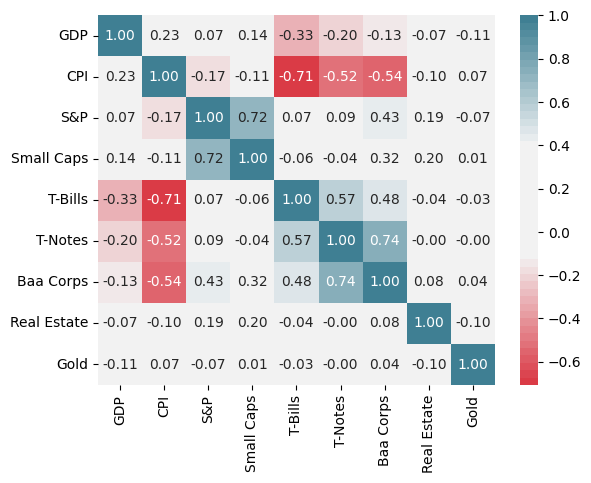

In [19]:
for col in plot_returns_df.columns:
    plot_returns_df[col] = plot_returns_df[col].astype(float)

# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(plot_returns_df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [20]:
# Drop CPI and GDP - not investable assets
labels = [label for label in list(plot_returns_df.columns) if label not in ['CPI', 'GDP']]

df = plot_returns_df[labels].copy()
df.head()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.454932,0.640465,0.042856,0.020148,0.044268,0.026781,0.012676
1929,-0.088311,-0.463935,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.200079,-0.448211,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.380674,-0.378275,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,0.018184,0.433809,0.126429,0.212472,0.377411,-0.002145,0.351646


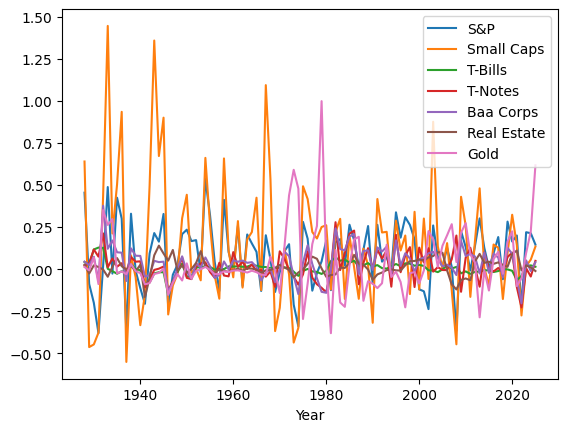

In [21]:
# Plot return series
df.plot.line();


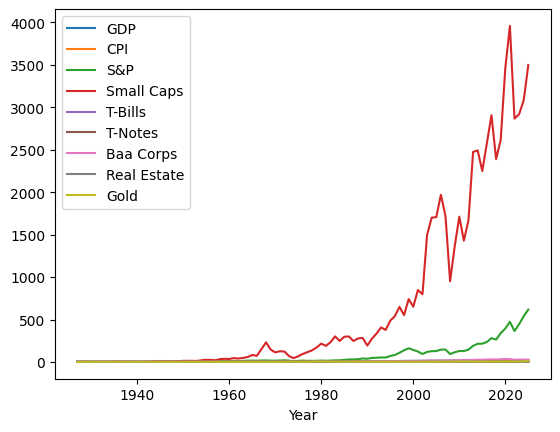

In [22]:
# Plot historical cumulative growth
total_return_index_df.plot.line();


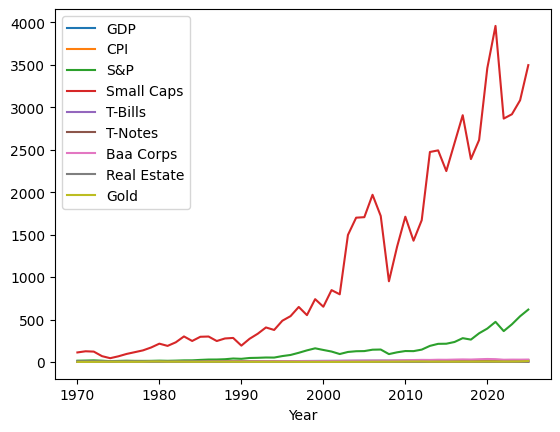

In [23]:
# plot historical cumulative growth since 1970
total_return_index_df.loc[1970:].plot.line();


# Long-only optimization

## 1928 - present 

In [24]:
df.head()


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.454932,0.640465,0.042856,0.020148,0.044268,0.026781,0.012676
1929,-0.088311,-0.463935,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.200079,-0.448211,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.380674,-0.378275,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,0.018184,0.433809,0.126429,0.212472,0.377411,-0.002145,0.351646


In [25]:
# Compute covariance matrix and optimization parameters
covariance_matrix = np.cov(df.transpose())
n_assets = covariance_matrix.shape[0]
mean_returns = df.mean().values
geometric_returns = (1+df).prod() ** (1 / n_periods) - 1

asset_vols = np.sqrt(covariance_matrix.diagonal())

# Display summary
summary_df = pd.DataFrame([mean_returns, geometric_returns, asset_vols], columns=labels)
summary_df = summary_df.transpose()
summary_df.columns = ['ret', 'geom_ret', 'std']
summary_df


,ret,geom_ret,std
S&P,0.086085,0.067763,0.193036
Small Caps,0.143763,0.086825,0.372899
T-Bills,0.003983,0.003260,0.038170
T-Notes,0.018336,0.014547,0.088592
Baa Corps,0.038559,0.034879,0.088005
Real Estate,0.012504,0.011280,0.049735
Gold,0.040702,0.024976,0.194296


In [26]:
# Solve max return portfolio (max return asset)
def max_return_portfolio(covariance_matrix, mean_returns, labels):
    n_assets = covariance_matrix.shape[0]
    w = cp.Variable(n_assets)
    ret = mean_returns.T @ w
    vol = cp.quad_form(w, covariance_matrix)

    prob = cp.Problem(
        cp.Maximize(ret),
        [cp.sum(w) == 1, w >= 0]
    )
    prob.solve(solver=SOLVER, **SOLVER_PARAMS)

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise ValueError(f"Optimization failed with status: {prob.status}")

    wts = [np.maximum(0, float(v)) for v in w.value]
    maxret1, maxretstd = compute_historical_metrics(df[labels], np.array(wts))
    maxretvol = vol.value
    maxretstd = np.sqrt(maxretvol)
    maxret = ret.value
    print(f"max variance (calculated):     {maxretstd**2}")
    print(f"max variance (from optimizer): {maxretvol}")
    print(f"max std (from optimizer):      {maxretstd}")

    print(f"max return (calculated):       {maxret1}")
    print(f"max return (from optimizer):   {maxret}")

    return maxret, maxretvol, pd.DataFrame([wts], columns=labels)

maxret, maxretvol, wts_df = max_return_portfolio(covariance_matrix, mean_returns, labels)
wts_df


max variance (calculated):     0.13905363254880188
max variance (from optimizer): 0.13905363254880188
max std (from optimizer):      0.3728989575592856
max return (calculated):       0.1437631449675881
max return (from optimizer):   0.1437631449675881


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
# Solve min volatility portfolio (other corner solution)
# should be mostly T-bills but there is variance in t-bills so it diversifies
def min_volatility_portfolio(covariance_matrix, mean_returns, labels):
    n_assets = covariance_matrix.shape[0]
    w = cp.Variable(n_assets)
    ret = mean_returns.T @ w
    vol = cp.quad_form(w, covariance_matrix)

    prob = cp.Problem(
        cp.Minimize(vol),
        [cp.sum(w) == 1, w >= 0]
        )
    prob.solve(solver=SOLVER, **SOLVER_PARAMS)

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise ValueError(f"Optimization failed with status: {prob.status}")

    wts = [np.maximum(0, float(v)) for v in w.value]
    minvol = vol.value
    print(f"Minimum vol:        {minvol}")
    minvolret = ret.value
    print(f"Minimum vol return: {minvolret}")
    wts_df = pd.DataFrame([wts], columns=labels)
    return minvol, minvolret, wts_df

minvol, minvolret, wts_df = min_volatility_portfolio(covariance_matrix, mean_returns, labels)
wts_df


Minimum vol:        0.0008326595102047276
Minimum vol return: 0.008401130265827153


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.000002,0.000002,0.596336,0.000000,0.000000,0.368961,0.034698


In [28]:
def solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxvol, NPOINTS, do_adjust):
    # Solve efficient frontier
    # For each volatility level, maximize return subject to volatility constraint

    # Generate volatility limits (linear spacing in std dev space, squared for variance)
    n_assets = covariance_matrix.shape[0]
    vol_std_targets = np.linspace(np.sqrt(minvol), np.sqrt(maxvol), NPOINTS)
    vol_targets = np.square(vol_std_targets)

    # Prepare parameters as list of dicts for keyword argument unpacking
    params_list = [
        {
            'vol_limit': vol_limit,
            'mu': mean_returns,
            'Sigma': covariance_matrix,
            'n': n_assets,
            'do_adjust': do_adjust
        }
        for vol_limit in vol_targets
    ]

    # Solve in parallel or single-thread
    if USE_PARALLEL:
        # For multiprocessing, need to use a wrapper or starmap
        def solve_with_dict(params_dict):
            return solve_portfolio_optimization(**params_dict)

        with Pool(processes=NPROCESSES) as pool:
            result_values = pool.map(solve_with_dict, params_list)
        results_dict = dict(zip(vol_targets, result_values))
    else:
        results_dict = {}
        for params in params_list:
            vol_limit = params['vol_limit']
            results_dict[vol_limit] = solve_portfolio_optimization(**params)

    for vol_limit, result in results_dict.items():
          if result is None:
              raise ValueError(f"Optimization failed for vol_limit={vol_limit}")
          if not isinstance(result, OptimizationResult):
              raise ValueError(f"Unexpected result type for vol_limit={vol_limit}")

    # Build scenarios DataFrame
    plot_ef_df = pd.DataFrame([result.weights for result in results_dict.values()], columns=labels)

    plot_ef_df['model_return'] = [result.return_val for result in results_dict.values()]
    plot_ef_df['model_std'] = [result.std_dev for result in results_dict.values()]
    plot_ef_df['objective'] = [result.objective for result in results_dict.values()]

    # Add historical metrics
    plot_ef_df = add_historical_metrics(plot_ef_df, df, labels)
    # weights for each asset, plus average return, standard deviation (log diff basis)
    return plot_ef_df


plot_ef_df = solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS, False)
plot_ef_df.tail()


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,model_return,model_std,objective,hist_return,hist_std
195,0.029768,0.970232,0.000000,0.000000,0.000000,0.000000,0.000000,0.142046,0.365984,0.142046,0.086934,0.365984
196,0.022308,0.977692,0.000000,0.000000,0.000000,0.000000,0.000000,0.142476,0.367712,0.142476,0.086911,0.367712
197,0.014860,0.985139,0.000000,0.000000,0.000000,0.000000,0.000000,0.142906,0.369441,0.142906,0.086885,0.369441
198,0.007425,0.992575,0.000000,0.000000,0.000000,0.000000,0.000000,0.143335,0.371170,0.143335,0.086856,0.371170
199,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.143763,0.372899,0.143763,0.086825,0.372899


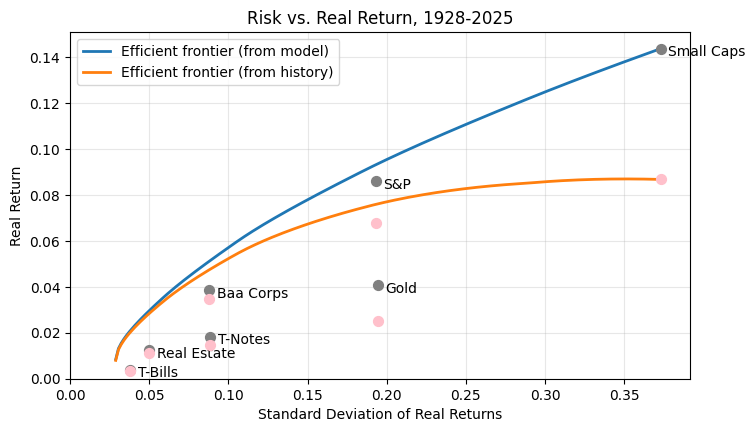

In [29]:
efrontier(plot_ef_df,
          df,
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_33714/2424115730.py:54: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  result = prob.solve(solver=SOLVER, **SOLVER_PARAMS)


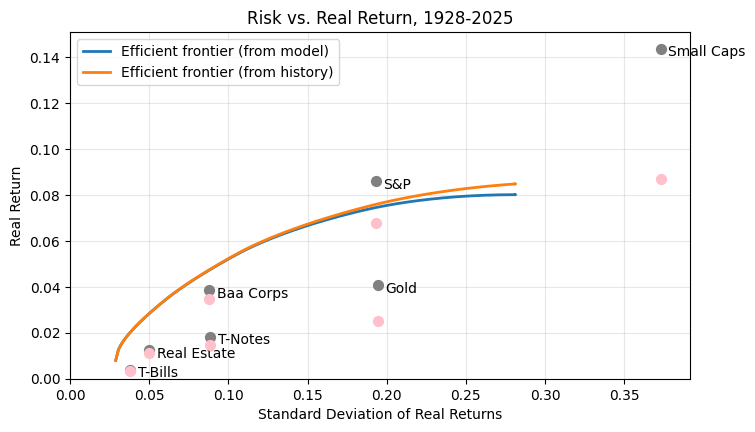

In [30]:
# maximize return adjusted for volatility
plot_ef_df = solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS, True)

efrontier(plot_ef_df,
          df,
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


In [31]:
print("100% small caps", (df["Small Caps"]+1).prod()**(1/len(df))-1)
print("100% S&P", (df["S&P"]+1).prod()**(1/len(df))-1)

z = df["Small Caps"] * 0.99 + df["S&P"]*.01
print("99% small caps, 1% S&P", (z+1).prod()**(1/len(df))-1)

# return goes up when you add a little S&P even though S&P has a lower arithmetic and geometric mean return
# hence efficient frontier is truncated before 100% small caps when return starts going down
# math is weird

100% small caps 0.08682473066105412
100% S&P 0.06776258429759907
99% small caps, 1% S&P 0.08686610986610832


In [32]:
plot_returns_df.columns


Index(['GDP', 'CPI', 'S&P', 'Small Caps', 'T-Bills', 'T-Notes', 'Baa Corps',
       'Real Estate', 'Gold'],
      dtype='object')

In [33]:
# drop duplicate rows (to 6 decimal places)
df_tmp = plot_ef_df[['model_return','model_std','objective']].round(6)
df_tmp = df_tmp.drop_duplicates()
plot_ef_df = plot_ef_df.loc[df_tmp.index]

In [34]:
plot_ef_df.tail()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,model_return,model_std,objective,hist_return,hist_std
143,0.393239,0.579463,0.000000,0.000000,0.000000,0.000000,0.027298,0.118269,0.276083,0.080158,0.084600,0.276083
144,0.391179,0.585111,0.000000,0.000000,0.000000,0.000000,0.023710,0.118757,0.277812,0.080168,0.084690,0.277812
145,0.389122,0.590749,0.000000,0.000000,0.000000,0.000000,0.020129,0.119245,0.279541,0.080173,0.084777,0.279541
146,0.387068,0.596378,0.000000,0.000000,0.000000,0.000000,0.016555,0.119732,0.281269,0.080176,0.084860,0.281269
147,0.386917,0.596791,0.000000,0.000000,0.000000,0.000000,0.016292,0.119768,0.281396,0.080176,0.084866,0.281396


In [35]:
df

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.454932,0.640465,0.042856,0.020148,0.044268,0.026781,0.012676
1929,-0.088311,-0.463935,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.200079,-0.448211,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.380674,-0.378275,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,0.018184,0.433809,0.126429,0.212472,0.377411,-0.002145,0.351646
1933,0.488460,1.447318,0.001952,0.010836,0.121111,-0.045406,0.262955
1934,-0.026634,0.212331,-0.012184,0.063520,0.170431,0.013703,0.297844
1935,0.424871,0.504102,-0.027359,0.014439,0.100235,0.065842,-0.024787
1936,0.300585,0.936041,-0.012585,0.035176,0.097926,0.017440,-0.013437


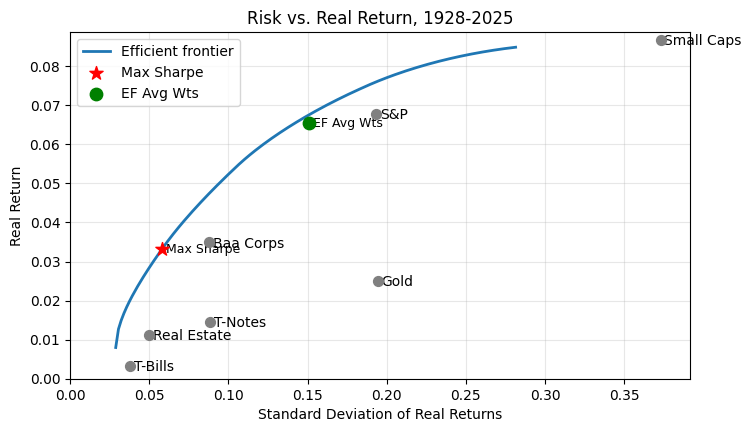

Max Sharpe Portfolio:
Real Return:  3.33%
SD:           5.82%
Sharpe Ratio: 0.572
S&P: 12.5%
Small Caps: 1.4%
T-Bills: 1.4%
Baa Corps: 31.2%
Real Estate: 41.7%
Gold: 11.7%
Average over entire efficient frontier:
Real Return:  6.56%
SD:           15.09%
Sharpe Ratio: 0.434
S&P: 34.3%
Small Caps: 23.1%
T-Bills: 3.1%
Baa Corps: 15.9%
Real Estate: 8.5%
Gold: 15.1%


In [36]:
portmetrics = plot_efrontier(plot_ef_df, df)


In [37]:
# change order
labels = ['Small Caps', 'S&P', 'T-Bills', 'T-Notes', 'Real Estate', 'Baa Corps', 'Gold']


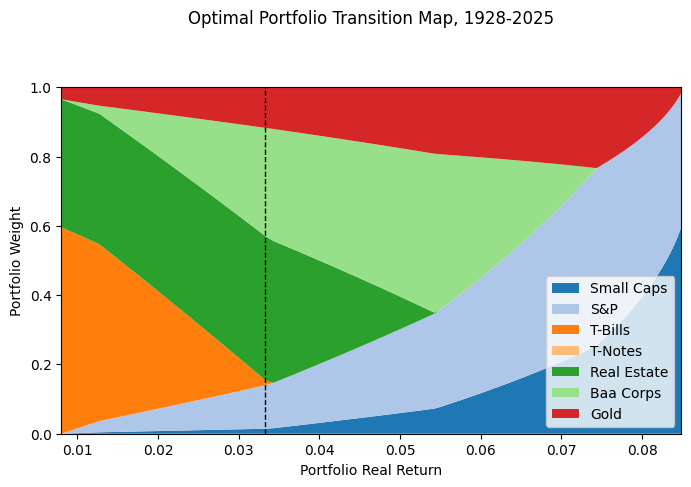

In [38]:
transition_map(plot_ef_df, asset_labels=labels,
              startyear=df.index[0], endyear=df.index[-1],
              max_sharpe_return=portmetrics.max_sharpe_return)


## 1967 - present (more inflationary era including post gold standard)

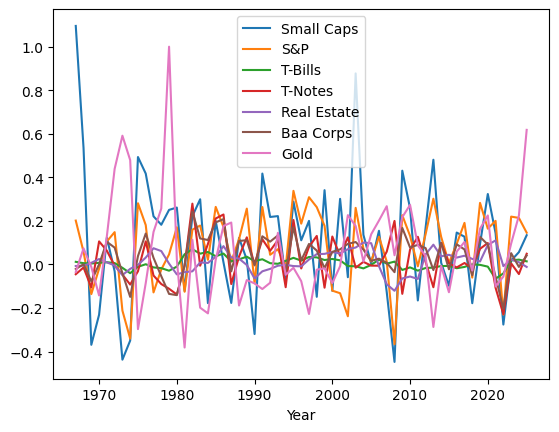

In [39]:
df = plot_returns_df.loc[1967:, labels]
df.plot.line();


In [40]:
# Compute covariance matrix and optimization parameters
covariance_matrix = np.cov(df[labels].transpose())
n_assets = covariance_matrix.shape[0]
mean_returns = df[labels].mean().values
asset_vols = np.sqrt(covariance_matrix.diagonal())

# Display summary
summary_df = pd.DataFrame([mean_returns, asset_vols], columns=labels)
summary_df = summary_df.transpose()
summary_df.columns = ['ret', 'std']
summary_df

,ret,std
Small Caps,0.105276,0.290348
S&P,0.080020,0.165671
T-Bills,0.005862,0.025402
T-Notes,0.022494,0.102640
Real Estate,0.013210,0.048816
Baa Corps,0.042654,0.089815
Gold,0.066808,0.234962


In [41]:
# max return
maxret, maxretvol, wts_df = max_return_portfolio(covariance_matrix, mean_returns, labels)
wts_df

max variance (calculated):     0.08430224933795684
max variance (from optimizer): 0.08430224933795684
max std (from optimizer):      0.29034849635904236
max return (calculated):       0.10527556687794755
max return (from optimizer):   0.10527556687794758


,Small Caps,S&P,T-Bills,T-Notes,Real Estate,Baa Corps,Gold
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
# min vol
minvol, minvolret, wts_df = min_volatility_portfolio(covariance_matrix, mean_returns, labels)
wts_df


Minimum vol:        0.0003658640400755
Minimum vol return: 0.009832520278140728


,Small Caps,S&P,T-Bills,T-Notes,Real Estate,Baa Corps,Gold
0,0.000000,0.000000,0.735856,0.000000,0.226271,0.000000,0.037873


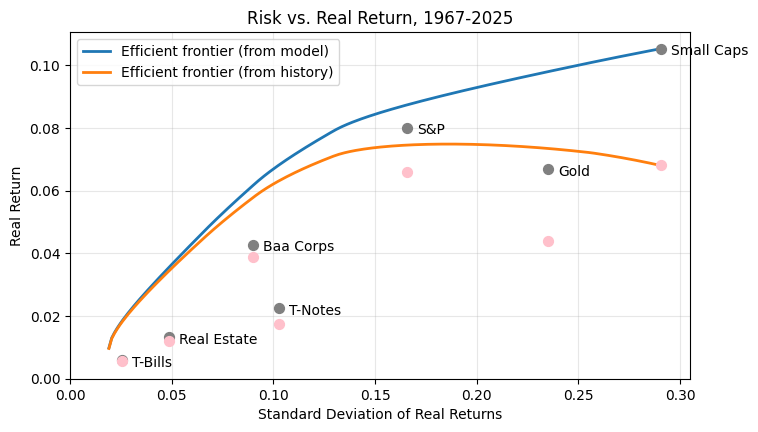

CPU times: user 564 ms, sys: 8.33 ms, total: 572 ms
Wall time: 675 ms


In [43]:
%%time
plot_ef_df = solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS, False)

efrontier(plot_ef_df,
          df,
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_33714/2424115730.py:54: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  result = prob.solve(solver=SOLVER, **SOLVER_PARAMS)


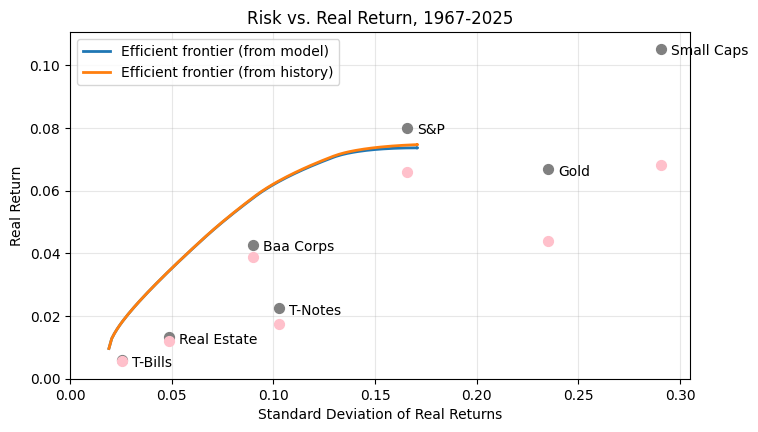

CPU times: user 770 ms, sys: 24.9 ms, total: 794 ms
Wall time: 978 ms


In [44]:
%%time
plot_ef_df = solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS, True)

efrontier(plot_ef_df,
          df,
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


In [45]:
# drop duplicate rows (to 6 decimal places)
df_tmp = plot_ef_df[['model_return','model_std','objective']].round(6)
df_tmp = df_tmp.drop_duplicates()
plot_ef_df = plot_ef_df.loc[df_tmp.index]


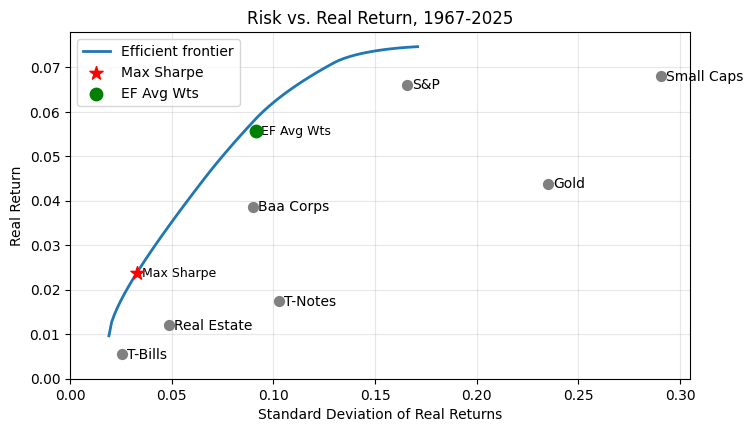

Max Sharpe Portfolio:
Real Return:  2.37%
SD:           3.28%
Sharpe Ratio: 0.725
Small Caps: 1.5%
S&P: 7.2%
T-Bills: 46.3%
Real Estate: 24.4%
Baa Corps: 11.4%
Gold: 9.3%
Average over entire efficient frontier:
Real Return:  5.56%
SD:           9.13%
Sharpe Ratio: 0.609
Small Caps: 11.9%
S&P: 29.9%
T-Bills: 10.4%
Real Estate: 9.9%
Baa Corps: 16.9%
Gold: 21.0%


In [46]:
portmetrics = plot_efrontier(plot_ef_df, df)


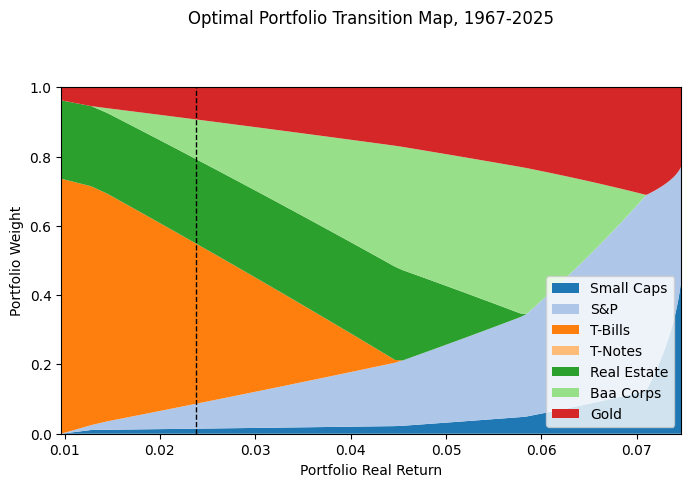

In [47]:
transition_map(plot_ef_df, asset_labels=labels,
              startyear=df.index[0], endyear=df.index[-1],
              max_sharpe_return=portmetrics.max_sharpe_return)


## 1983 - present (era of globalization, post-big inflation)


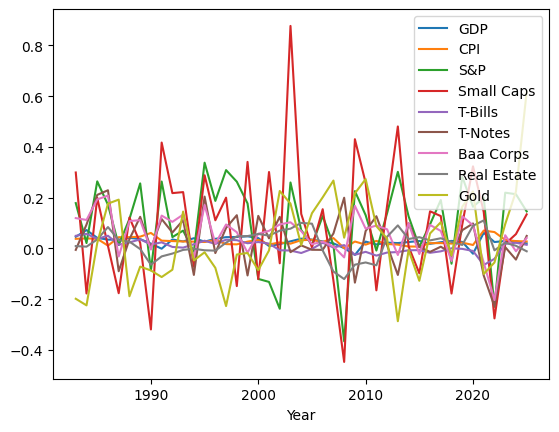

In [48]:
df = plot_returns_df.loc[1983:]
df.plot.line();


In [49]:
# Compute covariance matrix and optimization parameters
covariance_matrix = np.cov(df[labels].transpose())
n_assets = covariance_matrix.shape[0]
mean_returns = df[labels].mean().values
asset_vols = np.sqrt(covariance_matrix.diagonal())

# Display summary
summary_df = pd.DataFrame([mean_returns, asset_vols], columns=labels)
summary_df = summary_df.transpose()
summary_df.columns = ['ret', 'std']
summary_df


,ret,std
Small Caps,0.091851,0.243159
S&P,0.101203,0.159711
T-Bills,0.007349,0.025018
T-Notes,0.035090,0.099578
Real Estate,0.017788,0.052693
Baa Corps,0.058158,0.078713
Gold,0.038068,0.172240


In [50]:
# max return
maxret, maxretvol, wts_df = max_return_portfolio(covariance_matrix, mean_returns, labels)
wts_df

max variance (calculated):     0.025507602962360605
max variance (from optimizer): 0.02550760296236061
max std (from optimizer):      0.15971099825109292
max return (calculated):       0.10120291528515378
max return (from optimizer):   0.10120291528515378


,Small Caps,S&P,T-Bills,T-Notes,Real Estate,Baa Corps,Gold
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [51]:
# min vol
minvol, minvolret, wts_df = min_volatility_portfolio(covariance_matrix, mean_returns, labels)
wts_df


Minimum vol:        0.00040387936826143773
Minimum vol return: 0.010813117220961403


,Small Caps,S&P,T-Bills,T-Notes,Real Estate,Baa Corps,Gold
0,0.000000,0.000000,0.749857,0.000000,0.208083,0.000000,0.042060


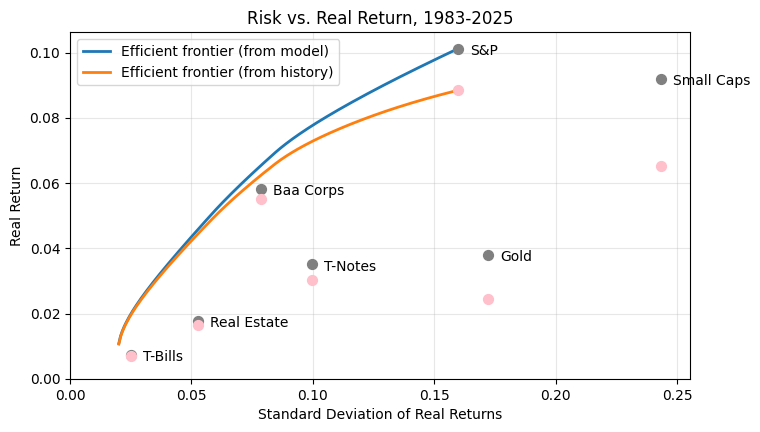

CPU times: user 581 ms, sys: 10.6 ms, total: 591 ms
Wall time: 613 ms


In [52]:
%%time
plot_ef_df = solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS, False)

efrontier(plot_ef_df,
          df[labels],
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_33714/2424115730.py:54: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  result = prob.solve(solver=SOLVER, **SOLVER_PARAMS)


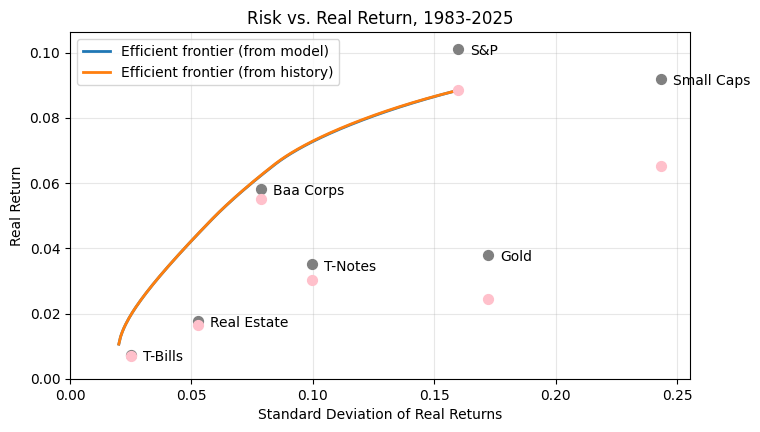

CPU times: user 619 ms, sys: 5.94 ms, total: 625 ms
Wall time: 626 ms


In [53]:
%%time
plot_ef_df = solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS, True)

efrontier(plot_ef_df,
          df[labels],
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


In [54]:
plot_ef_df

,Small Caps,S&P,T-Bills,T-Notes,Real Estate,Baa Corps,Gold,model_return,model_std,objective,hist_return,hist_std
0,0.000000,0.000000,0.749588,0.000000,0.208283,0.000000,0.042129,0.010817,0.020097,0.010615,0.010621,0.020097
1,0.001734,0.005375,0.694985,0.000000,0.225576,0.023590,0.048741,0.013050,0.020798,0.012834,0.012841,0.020798
2,0.000000,0.011863,0.665813,0.000000,0.229995,0.042227,0.050102,0.014548,0.021500,0.014317,0.014324,0.021500
3,0.000000,0.016395,0.642436,0.000000,0.232493,0.057481,0.051195,0.015808,0.022201,0.015561,0.015569,0.022201
4,0.000000,0.020425,0.621684,0.000000,0.234707,0.071018,0.052165,0.016927,0.022903,0.016665,0.016673,0.022903
5,0.000000,0.024109,0.602668,0.000000,0.236741,0.083430,0.053053,0.017952,0.023605,0.017673,0.017682,0.023605
6,0.000000,0.027562,0.584933,0.000000,0.238628,0.094994,0.053883,0.018909,0.024306,0.018613,0.018623,0.024306
7,0.000000,0.030818,0.568139,0.000000,0.240423,0.105956,0.054663,0.019814,0.025008,0.019501,0.019511,0.025008
8,0.000000,0.033931,0.552102,0.000000,0.242138,0.116420,0.055410,0.020678,0.025709,0.020348,0.020359,0.025709
9,0.000000,0.036927,0.536679,0.000000,0.243783,0.126475,0.056136,0.021510,0.026411,0.021161,0.021173,0.026411


In [55]:
# drop duplicate rows (to 6 decimal places)
df_tmp = plot_ef_df[['model_return','model_std','objective']].round(6)
df_tmp = df_tmp.drop_duplicates()
plot_ef_df = plot_ef_df.loc[df_tmp.index]


In [56]:
df

,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1983,0.045838,0.037910,0.178688,0.299342,0.049706,-0.005692,0.119503,0.009235,-0.198362
1984,0.072365,0.039487,0.021140,-0.177479,0.057445,0.094130,0.112272,0.007018,-0.224402
1985,0.041696,0.037987,0.264324,0.199534,0.037778,0.211118,0.193297,0.035383,0.021214
1986,0.034627,0.010979,0.172078,0.009813,0.049972,0.229345,0.208197,0.084220,0.176647
1987,0.034546,0.044344,0.013198,-0.176516,0.014608,-0.089960,-0.031763,0.032700,0.192398
1988,0.041770,0.044194,0.116049,0.121918,0.023660,0.036432,0.107853,0.026831,-0.188418
1989,0.036722,0.046473,0.256365,0.022100,0.035765,0.124670,0.111468,-0.002418,-0.071545
1990,0.018860,0.061063,-0.086430,-0.319267,0.015491,0.001217,-0.004321,-0.064017,-0.086867
1991,-0.001083,0.030643,0.263627,0.417271,0.024021,0.115852,0.129393,-0.031366,-0.112765


In [57]:
df[labels]

,Small Caps,S&P,T-Bills,T-Notes,Real Estate,Baa Corps,Gold
Year,,,,,,,
1983,0.299342,0.178688,0.049706,-0.005692,0.009235,0.119503,-0.198362
1984,-0.177479,0.021140,0.057445,0.094130,0.007018,0.112272,-0.224402
1985,0.199534,0.264324,0.037778,0.211118,0.035383,0.193297,0.021214
1986,0.009813,0.172078,0.049972,0.229345,0.084220,0.208197,0.176647
1987,-0.176516,0.013198,0.014608,-0.089960,0.032700,-0.031763,0.192398
1988,0.121918,0.116049,0.023660,0.036432,0.026831,0.107853,-0.188418
1989,0.022100,0.256365,0.035765,0.124670,-0.002418,0.111468,-0.071545
1990,-0.319267,-0.086430,0.015491,0.001217,-0.064017,-0.004321,-0.086867
1991,0.417271,0.263627,0.024021,0.115852,-0.031366,0.129393,-0.112765


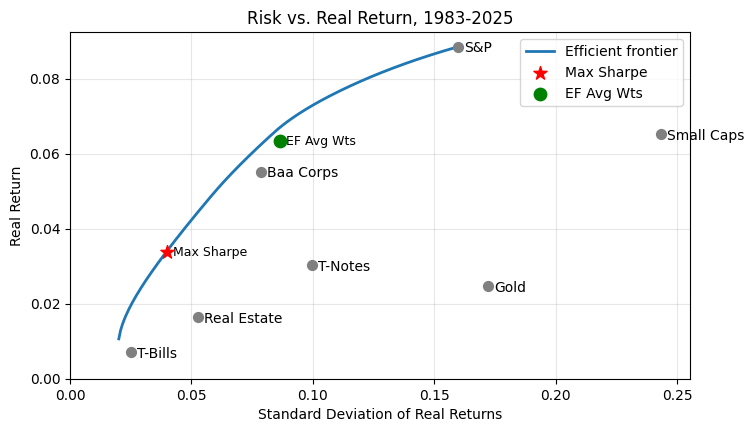

Max Sharpe Portfolio:
Real Return:  3.39%
SD:           3.97%
Sharpe Ratio: 0.852
S&P: 8.4%
T-Bills: 29.3%
Real Estate: 27.0%
Baa Corps: 28.5%
Gold: 6.8%
Average over entire efficient frontier:
Real Return:  6.35%
SD:           8.63%
Sharpe Ratio: 0.736
S&P: 42.6%
T-Bills: 8.8%
Real Estate: 10.0%
Baa Corps: 34.1%
Gold: 4.5%


In [58]:
portmetrics = plot_efrontier(plot_ef_df, df[labels])


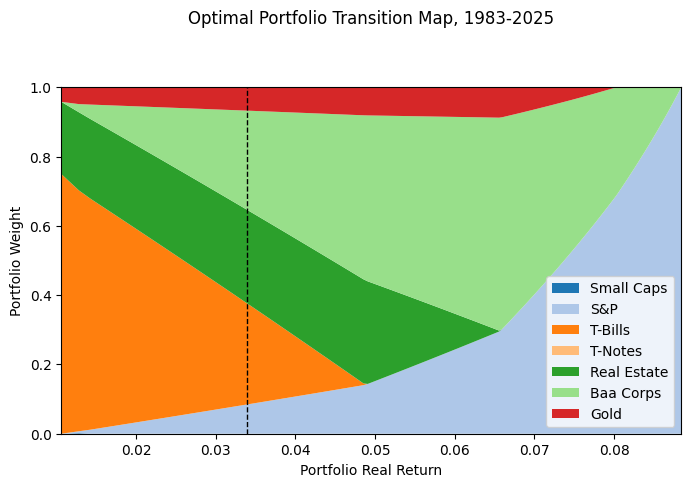

In [59]:
transition_map(plot_ef_df, asset_labels=labels,
              startyear=df.index[0], endyear=df.index[-1],
              max_sharpe_return=portmetrics.max_sharpe_return)


## Add a risk-free asset
- The efficient frontier above does not include a risk-free asset, when we inflation-adjust t-bill returns we get volatility and fluctuation in returns including periods of negative real returns.
- However TIPS are available which offer a guaranteed real pre-tax return. They are issued at a real rate, the principal gets adjusted for inflation, and if there is deflation you can't get back less than par. So when you buy TIPS you are guaranteed a positive real pre-tax return
- TIPS offer an inflation hedge and a safe real return, so they might dominate gold. There isn't a great theoretical argument gold should increase in value faster than inflation in the long run (gold bugs might disagree but in a fiat world, that's my story and I'm sticking to it). I could see reasonable arguments why gold should maintain its real value if supply is fixed, and there should be demand for gold when there is inflation and people lose faith in monetary authorities because it is currency-like and supply is relatively fixed, so gold offers an inflation hedge. 
- TIPS total returns are only available for approximately the last 25 years. You can model the TIPS yield as the yield on similar nominal Treasuries less inflation expectations. Hypothetically, there might be a sound way to model historical inflation expectations using recent inflation trends, gold, steepness of yield curve etc. And from there, model what TIPS total returns would theoretically have been based on Treasury total returns and changes in inflation expectations, but that is a challenge. We could also say that the best inflation hedge was gold up to 2000 and TIPS thereafter and use VIPSX OR TIP, but that is a kinky Franken-asset.
- We could also say that given the existence of TIPS, a risk-free 0 real yield asset is available. Worst case TIPS return is 0, if auction rate is 0. Or you could buy TIPS and donate any return over 0, and you are guaranteed return of principal plus inflation. You could argue that it wasn't available and if it had been then it would have modified other returns. If my aunt had wheels she'd be a bicycle.
- Lets posit that we are justified in adding a risk-free TIPS asset, with a constant zero return.
- In the real world you would get a positive real return on TIPS with some fluctuations, real TIPS should dominate the risk-free asset. So this model might underweight TIPS.


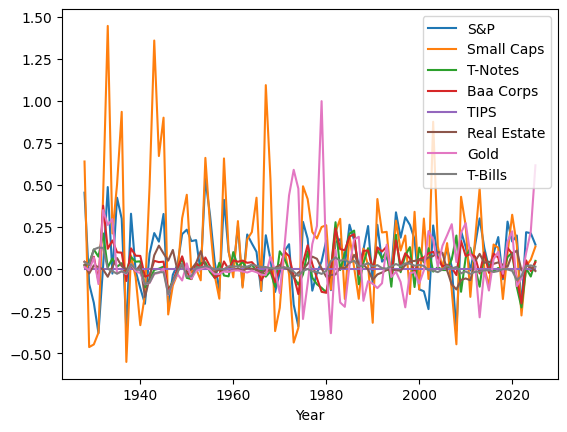

In [60]:
df = plot_returns_df.copy()
df["TIPS"] = 0
# reorder  for chart
df = df[[ 'S&P', 'Small Caps', 'T-Notes', 'Baa Corps', 'TIPS', 'Real Estate', 'Gold', 'T-Bills' ]]
labels = df.columns
df.plot.line();

In [61]:
# Compute covariance matrix and optimization parameters
covariance_matrix = np.cov(df[labels].transpose())
n_assets = covariance_matrix.shape[0]
mean_returns = df[labels].mean().values
asset_vols = np.sqrt(covariance_matrix.diagonal())

# Display summary
summary_df = pd.DataFrame([mean_returns, asset_vols], columns=labels)
summary_df = summary_df.transpose()
summary_df.columns = ['ret', 'std']
summary_df


,ret,std
S&P,0.086085,0.193036
Small Caps,0.143763,0.372899
T-Notes,0.018336,0.088592
Baa Corps,0.038559,0.088005
TIPS,0.000000,0.000000
Real Estate,0.012504,0.049735
Gold,0.040702,0.194296
T-Bills,0.003983,0.038170


In [62]:
# max return
maxret, maxretvol, wts_df = max_return_portfolio(covariance_matrix, mean_returns, labels)
wts_df


max variance (calculated):     0.13905363253148006
max variance (from optimizer): 0.13905363253148006
max std (from optimizer):      0.3728989575360597
max return (calculated):       0.14376314495925036
max return (from optimizer):   0.1437631449592503


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [63]:
# min vol
minvol, minvolret, wts_df = min_volatility_portfolio(covariance_matrix, mean_returns, labels)
wts_df


Minimum vol:        9.450045854326383e-11
Minimum vol return: 5.476926127158444e-06


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
0,0.000014,0.000008,0.000029,0.000023,0.999809,0.000048,0.000021,0.000048


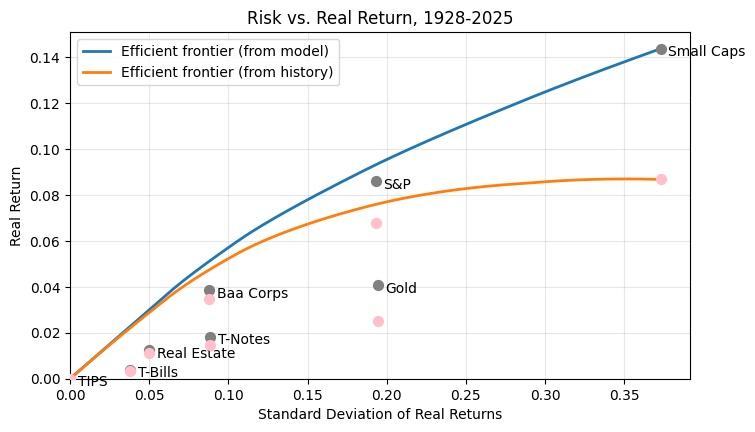

CPU times: user 561 ms, sys: 10.3 ms, total: 571 ms
Wall time: 714 ms


In [64]:
%%time
plot_ef_df = solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS, False)

efrontier(plot_ef_df,
          df[labels],
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


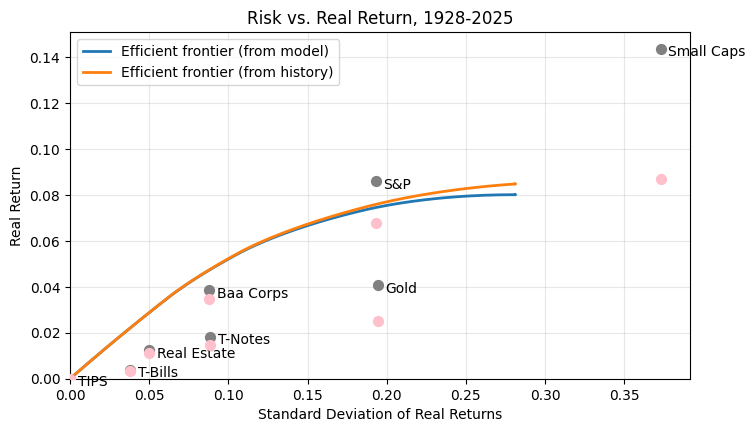

CPU times: user 594 ms, sys: 4.67 ms, total: 599 ms
Wall time: 600 ms


In [65]:
%%time
plot_ef_df = solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS, True)

efrontier(plot_ef_df,
          df[labels],
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


In [66]:
# drop duplicate rows (to 6 decimal places)
df_tmp = plot_ef_df[['model_return','model_std','objective']].round(6)
df_tmp = df_tmp.drop_duplicates()
plot_ef_df = plot_ef_df.loc[df_tmp.index]


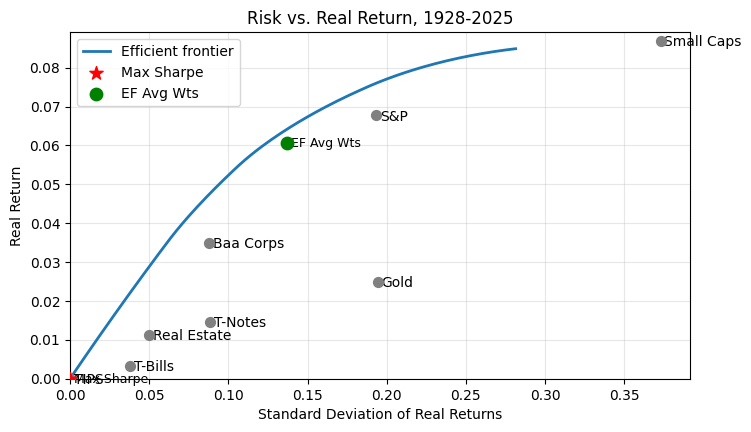

Max Sharpe Portfolio:
Real Return:  0.00%
SD:           0.00%
Sharpe Ratio: 0.601
TIPS: 100.0%
Average over entire efficient frontier:
Real Return:  6.06%
SD:           13.73%
Sharpe Ratio: 0.442
S&P: 31.3%
Small Caps: 20.8%
Baa Corps: 15.7%
TIPS: 11.1%
Real Estate: 7.1%
Gold: 13.9%


In [67]:
portmetrics = plot_efrontier(plot_ef_df, df)


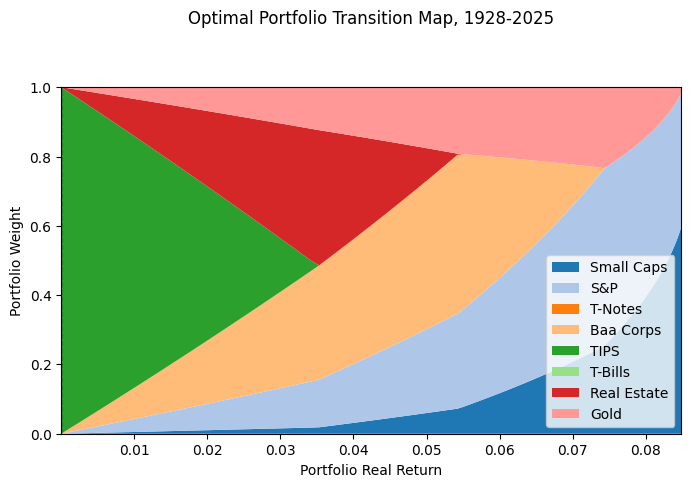

In [68]:
labels = ['Small Caps', 'S&P', 'T-Notes', 'Baa Corps', 'TIPS', 'T-Bills','Real Estate',
       'Gold']
transition_map(plot_ef_df, asset_labels=labels,
              startyear=df.index[0], endyear=df.index[-1],
              max_sharpe_return=portmetrics.max_sharpe_return)


In [69]:
# midwit regularization - take the mean of all optimal portfolios at any level of risk
# risk/return deemed unreasonable above here, sharpe < 0.5
# ret_cutoff = 0.065001
ret_cutoff = 0.25001

regularized = plot_ef_df.loc[plot_ef_df['hist_return'] <=  ret_cutoff][['S&P', 'Small Caps', 'T-Notes',
       'Baa Corps', 'TIPS', 'Real Estate', 'Gold', 'T-Bills']].mean()
with pd.option_context('display.float_format', '{:.6f}'.format):
    display(regularized)


S&P           0.313351
Small Caps    0.208161
T-Notes       0.000000
Baa Corps     0.156937
TIPS          0.111495
Real Estate   0.071488
Gold          0.138568
T-Bills       0.000000
dtype: float64

# Long/short optimization with leverage constraint

In [70]:
real_data_df = plot_returns_df


In [71]:
# in order to include shorts, we need an asset with a poor expected return
# assume I can identify bad stocks, they are highly correlated with S&P but return negative 5%
# create a synthetic 'shorts' asset
real_data_df = plot_returns_df.copy()

n = len(real_data_df)
def generate_correlated_series(x1, target_corr, mean_return):
    """given a series x1, return a random series with correlation target_corr to x1"""
    n = len(x1)
    theta = np.arccos(target_corr)

    x2 = np.random.normal(0, x1.std(), size=n)
    # center so actual mean = 0
    X = pd.DataFrame({'x1': x1 - x1.mean(),
                      'x2': x2 - x2.mean()
                     })
    # identity matrix
    Id = np.diag(np.ones(n))
    # QR factorization
    Q = np.linalg.qr(X[['x1']])[0]
    P = Q @ Q.T
    x2o = (Id - P) @ X[['x2']]
    Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
    # divide by l2 norm
    Y = Xc2 / np.sqrt(np.sum(np.square(Xc2), axis=0))
    return Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return

shorts = generate_correlated_series(real_data_df['S&P'].values, 0.9, -0.05)
print("mean return %.04f" % shorts.mean())
print("vol %.04f" % shorts.std())
np.corrcoef(shorts, real_data_df['S&P'])



mean return -0.0500
vol 0.2329


array([[1. , 0.9],
       [0.9, 1. ]])

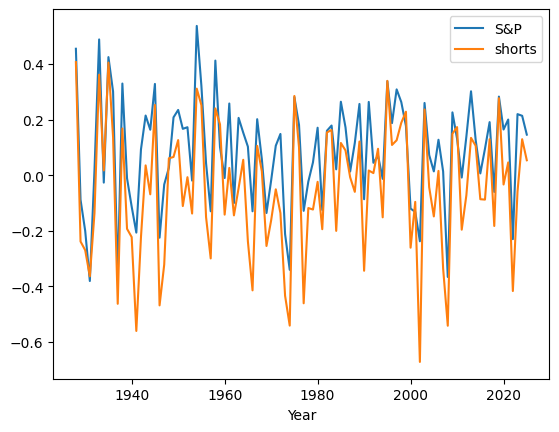

In [72]:
labels = ['S&P', 'Small Caps', 'Real Estate', 'T-Bills', 'T-Notes', 'Gold', 'Baa Corps', 'shorts']
df = real_data_df[['S&P', 'Small Caps', 'Real Estate', 'T-Bills', 'T-Notes', 'Gold', 'Baa Corps']].copy()
df['shorts'] = shorts.to_list()

df[['S&P', 'shorts']].plot.line();

In [73]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Small Caps,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,shorts
rows,,,,,,,,
real return,0.086085,0.143763,0.012504,0.003983,0.018336,0.040702,0.038559,-0.050000
vol,0.193036,0.372899,0.049735,0.038170,0.088592,0.194296,0.088005,0.232936


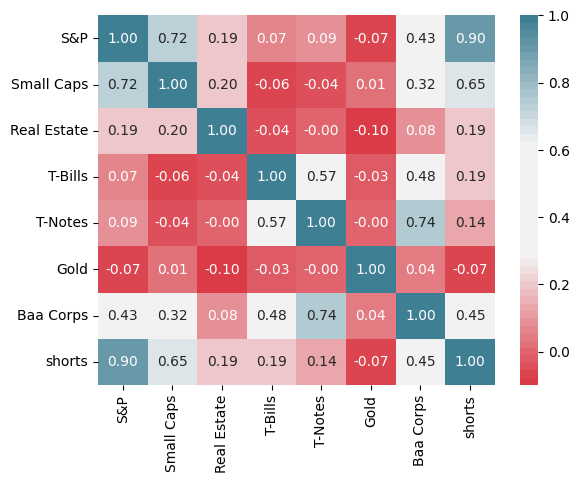

In [74]:
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [75]:
# doesn't use shorts and leverage constraint
maxret, maxretvol, wts_df = max_return_portfolio(Sigma, mu, labels)
wts_df


max variance (calculated):     0.13905363255149275
max variance (from optimizer): 0.13905363255149278
max std (from optimizer):      0.37289895756289365
max return (calculated):       0.14376314496438777
max return (from optimizer):   0.14376314496438777


,S&P,Small Caps,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,shorts
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [76]:
# min vol
minvol, minvolret, wts_df = min_volatility_portfolio(Sigma, mu, labels)
wts_df


Minimum vol:        0.0008326594639720327
Minimum vol return: 0.00840106392715392


,S&P,Small Caps,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,shorts
0,0.000002,0.000001,0.368962,0.596336,0.000000,0.034698,0.000000,0.000000


In [77]:
maxretvol


np.float64(0.13905363255149278)

In [78]:
def solve_portfolio_optimization_longshort(
    vol_limit: float,
    mu: npt.NDArray[np.float64],
    Sigma: npt.NDArray[np.float64],
    n: int,
    do_adjust: bool = False
) -> OptimizationResult:
    """
    Solve portfolio optimization for given parameters using convex optimization.

    Maximizes portfolio return subject to volatility constraint and long-only
    constraint.

    Parameters
    ----------
    vol_limit : float
        Variance limit constraint
    mu : npt.NDArray[np.float64]
        Expected returns vector
    Sigma : npt.NDArray[np.float64]
        Covariance matrix
    n : int
        Number of assets
    do_adjust : bool, default=False
        Should objective be penalized for volatility to address volatility drag

    Returns
    -------
    OptimizationResult
        Named tuple with fields:
        - return_val : float - Optimized portfolio return
        - std_dev : float - Portfolio standard deviation
        - weights : npt.NDArray[np.float64] - Asset weights

    Raises
    ------
    ValueError
        If optimization fails, returns None values, or weights don't sum to 1.0
    """
    # Create optimization variables and problem
    w = cp.Variable(n)
    ret = mu.T @ w
    vol = cp.quad_form(w, Sigma)
    # adjusted return or return depending on do_adjust
    objective = ret - vol/2 if do_adjust else ret

    prob = cp.Problem(
        cp.Maximize(objective),
        [cp.norm1(w) <= 1.5, cp.sum(w) == 1, vol <= vol_limit]
    )

    result = prob.solve(solver=SOLVER, **SOLVER_PARAMS)

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        print(f"""Optimization failed with status '{prob.status}' for vol_limit={vol_limit}.
Problem may be infeasible or solver encountered an error."""
             )
        return None

    # Validate results exist
    if ret.value is None or vol.value is None or w.value is None:
        print(f"Optimization returned None values for vol_limit={vol_limit}.")
        return None
    
    # Validate weights sum to 1.0 (within numerical precision)
    weight_sum = w.value.sum()
    if abs(weight_sum - 1.0) > WEIGHT_SUM_TOLERANCE:
        print(f"Weights sum to {weight_sum:.6f}, not 1.0. Check constraints.")
        return None

    return OptimizationResult(
        return_val=ret.value,
        std_dev=np.sqrt(vol.value),
        objective=objective.value,
        weights=w.value
    )


In [79]:
# compute covariance matrix
covariance_matrix = Sigma 
n_assets = covariance_matrix.shape[0]
mean_returns = df.mean().values
asset_vols = np.sqrt(Sigma.diagonal())

vol_std_targets = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vol_targets = np.square(vol_std_targets)

do_adjust=False
# Prepare parameters as list of dicts for keyword argument unpacking
params_list = [
    {
        'vol_limit': vol_limit,
        'mu': mean_returns,
        'Sigma': covariance_matrix,
        'n': n_assets,
        'do_adjust': do_adjust
    }
    for vol_limit in vol_targets
]

results_dict = {}
for params in params_list:
    vol_limit = params['vol_limit']
    results_dict[vol_limit] = solve_portfolio_optimization_longshort(**params)

for vol_limit, result in results_dict.items():
      if result is None:
          print(f"Optimization failed for vol_limit={vol_limit}")
      if not isinstance(result, OptimizationResult):
          print(f"Unexpected result type for vol_limit={vol_limit}")

# Build scenarios DataFrame
results_values = [result for result in results_dict.values() if result]
plot_ef_df = pd.DataFrame([result.weights for result in results_values if result], columns=labels)

plot_ef_df['model_return'] = [result.return_val for result in results_values]
plot_ef_df['model_std'] = [result.std_dev for result in results_values]
plot_ef_df['objective'] = [result.objective for result in results_values]

# Add historical metrics
plot_ef_df = add_historical_metrics(plot_ef_df, df, labels)


In [80]:
plot_ef_df


,S&P,Small Caps,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,shorts,model_return,model_std,objective,hist_return,hist_std
0,0.183036,0.001703,0.329622,0.648329,-0.061626,0.032406,0.032867,-0.166336,0.032478,0.028856,0.032478,0.032077,0.028856
1,0.229621,0.003599,0.323468,0.622932,-0.043455,0.033856,0.036524,-0.206545,0.039127,0.030585,0.039127,0.038680,0.030585
2,0.265110,0.005791,0.319909,0.595486,-0.013873,0.035538,0.028166,-0.236127,0.044111,0.032314,0.044111,0.043615,0.032314
3,0.288806,0.007605,0.321254,0.544999,0.000000,0.041173,0.046163,-0.250000,0.048099,0.034042,0.048099,0.047551,0.034042
4,0.299806,0.008826,0.325948,0.486395,0.000000,0.048723,0.080303,-0.250000,0.050670,0.035771,0.050670,0.050067,0.035771
5,0.308493,0.009790,0.329655,0.440108,0.000000,0.054685,0.107269,-0.250000,0.052701,0.037500,0.052701,0.052039,0.037500
6,0.316050,0.010627,0.332880,0.399853,0.000000,0.059871,0.130720,-0.250000,0.054467,0.039229,0.054467,0.053744,0.039229
7,0.322909,0.011391,0.335806,0.363294,0.000000,0.064581,0.152019,-0.250000,0.056071,0.040958,0.056071,0.055283,0.040958
8,0.329298,0.012101,0.338534,0.329246,0.000000,0.068967,0.171854,-0.250000,0.057565,0.042687,0.057565,0.056710,0.042687
9,0.335343,0.012772,0.341114,0.297036,0.000000,0.073116,0.190618,-0.250000,0.058979,0.044416,0.058979,0.058052,0.044416


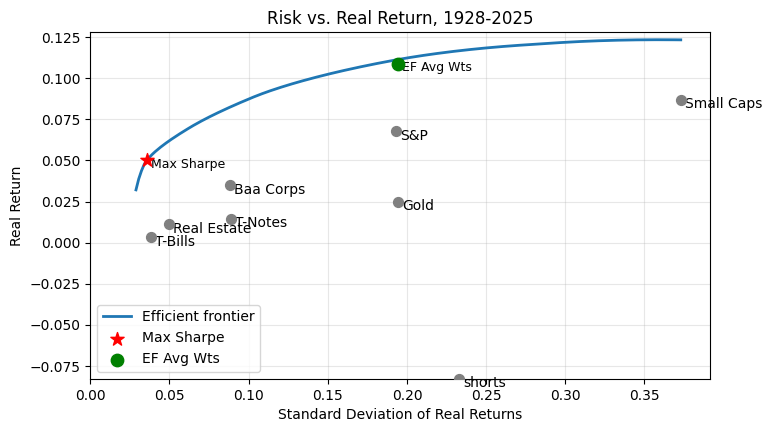

Max Sharpe Portfolio:
Real Return:  5.01%
SD:           3.58%
Sharpe Ratio: 1.400
S&P: 30.0%
Small Caps: 0.9%
Real Estate: 32.6%
T-Bills: 48.6%
Gold: 4.9%
Baa Corps: 8.0%
Average over entire efficient frontier:
Real Return:  10.87%
SD:           19.42%
Sharpe Ratio: 0.560
S&P: 55.5%
Small Caps: 38.4%
Real Estate: 5.5%
T-Bills: 3.1%
Gold: 10.2%
Baa Corps: 12.3%


In [81]:
portmetrics = plot_efrontier(plot_ef_df, df)


In [82]:
plot_ef_df.columns

Index(['S&P', 'Small Caps', 'Real Estate', 'T-Bills', 'T-Notes', 'Gold',
       'Baa Corps', 'shorts', 'model_return', 'model_std', 'objective',
       'hist_return', 'hist_std', 'Sharpe'],
      dtype='object')

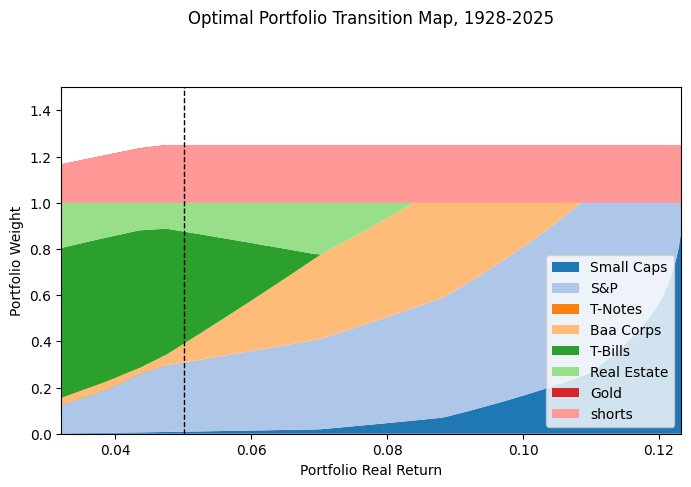

In [83]:
# need to rewrite this to show shorts
labels = ['Small Caps', 'S&P', 'T-Notes', 'Baa Corps', 'T-Bills','Real Estate',
       'Gold', 'shorts']
transition_map(plot_ef_df, asset_labels=labels,
              startyear=df.index[0], endyear=df.index[-1],
              max_sharpe_return=portmetrics.max_sharpe_return,
              ylim=1.5)


# Alternative approaches

- If we thought returns were really IID log normally distributed and covariance stationary, then this optimization approach whould generate an optimal forward-looking efficient frontier.
- But we can see that there are regime changes so covariance stationarity isn't a very good assumption, nor is log normality.
- Since we might be overfitting to a particular past regime, we might want to regularize, which is to say back off from the model's maximum in a systematic way towards a more diversified solution robust to regime changes, while still near optimal.
- A few regularization approaches with thanks to [Roman Rubsamen and PortfolioOptimizer.io](https://portfoliooptimizer.io):
    - Just add a vol penalty to the optimization to force a lower risk, more diversified portfolio at each level of return. (we are already adding a vol penalty to adjust for the 'volatility drag' from using percent change instead of e.g. log diffs, we can increase the penalty)
    - [Near optimal portfolios](https://portfoliooptimizer.io/blog/mean-variance-optimization-in-practice-well-diversified-near-efficient-portfolios/) One approach is, first find the highest Sharpe portfolio. Then we can say, find the lowest risk portfolio with no more than e.g. a 0.05 drop in Sharpe ratio. Since this portfolio is more diversified, i.e. most diversified within 0.05 of maximum Sharpe, it should be more robust out-of-sample.
    - [Subset resampled portfolios](https://portfoliooptimizer.io/blog/mean-variance-optimization-in-practice-subset-resampling-based-efficient-portfolios/), Suppose we have 6 assets, do 6 optimizations, dropping one asset each time, then average all the portfolios. Similar to random forest, an ensemble of slightly weakened models performs better out of sample than a single overfitted model.
    - [Michaud resampling](https://docs.portfoliooptimizer.io/index.html#post-/portfolios/analysis/mean-variance/efficient-frontier/resampling-based) and [MCOS](https://github.com/enjine-com/mcos/tree/master). Do Monte Carlo simulations where we perturb the return forecasts and covariances randomly each time, and average all the resulting portfolios.
    - [Black-Litterman](https://en.wikipedia.org/wiki/Black%E2%80%93Litterman_model). First estimate a covariance matrix and average returns. Then look at the current market cap of all the assets. Ask yourself, what returns would make this portfolio optimal assuming your covariance matrix? That is what the market is pricing in. That is your Bayesian prior. Then ask yourself, what do you think the correct returns are that would surprise you least? then decide how confident you are and perform a Bayesian update to your prior based on your confidence. Or start with the portfolio based on your prediction and dial confidence down until it is closer to the market's prediction. Interesting but complicated.
    - [Hierarchical Risk Parity](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678) and related methods like Nested Cluster Optimization. Create a tree of assets clustered by similarity. Then starting at the bottom at each non-leaf create a risk parity portfolio of assets under the node, and recursively climb the tree to get a global portfolio. If you create an portfolio of t-bonds and notes and bills and corporates (NCO) and MBS and munis, we will get some of each, even if one is dominated under MV optimization. Same if you do US stocks and various international markets with different market caps and geographies. Then as you combine clusters, all asset classes are represented, whereas a global optimization might omit some assets. Vanilla HRP actually ignores returns, substitutes the clustering order for the covariance matrix, and creates a minimum risk portfolio assuming no covariance at each level. Which ignores a lot of information. Schur portfolios let you split the difference between vanilla HRP and using the return and covariance information.
    - Or the naive approach above, where we just average over the entire efficient frontier. One could do something more systematic and test how much regularization works best out of sample. One could average over e.g. all the efficient frontiers for 10- or 20-year periods or something.
- To sum up
    - If you do know your future returns and covariances, the efficient frontier and MV optimization give an optimal answer
    - And also in that case, if you can invest or borrow at the risk free rate (or close), you can do best with the Sharpe-optimal portfolio plus leverage or deleverage vs. moving left or right along the frontier due to its convexity properties
    - However, you probably don't have really accurate forecasts, and even really smart and sophisticated investors get burned by leverage. For instance before the financial crisis, Citibank and Harvard both decided they should be taking more risk and leverage and got burned.
    - Historically taking equity risk has been well compensated: the ['equity premium puzzle'](https://en.wikipedia.org/wiki/Equity_premium_puzzle).. Conventional wisdom is that if you have a long term horizon and are able to weather swings in equity returns without selling low, then you should hold more equity than suggested by these Sharpe-optimal portfolios. See this [paper](https://www.nber.org/system/files/working_papers/w10483/w10483.pdf), do a web search for 'equity premium puzzle' or have a conversation with your favorite advanced AI about what various eminent professors of finance have said about it.
    - For these reasons you probably want to back off from MV optimal portfolios in the direction of more diversification and robustness to regime change, and if you prefer more risk and return than the Sharpe portfolio, you may want to move along the curve instead of using leverage.
    - If you can perturb forecasts in a way that models past regime changes well, Michaud resampling seems like a sound approach. I would need to do more work to understand that and parameterize it though.
    - A simple average of portfolios along the frontier is directionally similar and not massively suboptimal, and easier to explain and offers more diversification. It's near optimal without the 'near'. So it could be considered a 'not-too-far-from-optimal asset allocation for midwits', or a naive base case. It may be the simplest, dumbest asset allocation that might possibly work, as a starting point.


# Hierarchical risk parity

- Using the correlation matrix we can cluster assets into similar clusters and put equal risk into each cluster
  - Use agglomerative clustering to make a binary tree of assets
  - Start at individual assets, combine the 2 most correlated into a cluster
  - Continue iteratively combining the most correlated assets or clusters into bigger clusters, until you arrive at the root.
  - Now starting at the leaf nodes, allocate each asset to its parent cluster in inverse proportion to variance, and continue iteratively up the tree.
  - A heuristic way to create a low variance portfolio, but unlike the minimum-variance optimization it's not very sensitive to small changes in correlations and doesn't use a return forecast. Kind of a poor man's minimum variance portfolio.
    

In [84]:
# 1928-present
df = real_data_df.loc[1928:].copy()
df = df.drop(columns=['CPI', 'GDP'], errors='ignore')
labels = df.columns


In [85]:
# show returns and vols
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
rows,,,,,,,
real return,0.086085,0.143763,0.003983,0.018336,0.038559,0.012504,0.040702
vol,0.193036,0.372899,0.038170,0.088592,0.088005,0.049735,0.194296


In [86]:
# Building a Riskfolio portfolio object
port = rp.HCPortfolio(returns=df)

# Estimate optimal portfolio:

model='HRP'
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage_method = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage_method,
                      max_k=max_k,
                      leaf_order=leaf_order)
display(w.T)
# concentrated but should be less concentrated than minimum variance portfolio which is:
# 	S&P	Real Estate	T-Bills	T-Notes	Gold	Baa Corps
# 	0.001076	0.361574	0.599897	-0.0	0.037453	-0.0


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
weights,0.016518,0.005560,0.472399,0.087691,0.079474,0.312553,0.025806


In [87]:
# Nested Cluster Optimization
df = df.loc[1928:]
labels = df.columns

# Building the portfolio object
port = rp.HCPortfolio(returns=df)

# Estimate optimal portfolio:

model='NCO'
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage_method = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage_method,
                      max_k=max_k,
                      leaf_order=leaf_order)
display(w.T)  # more concentrated than HRP

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
weights,0.000000,0.000000,0.602777,0.000000,0.000000,0.362645,0.034578


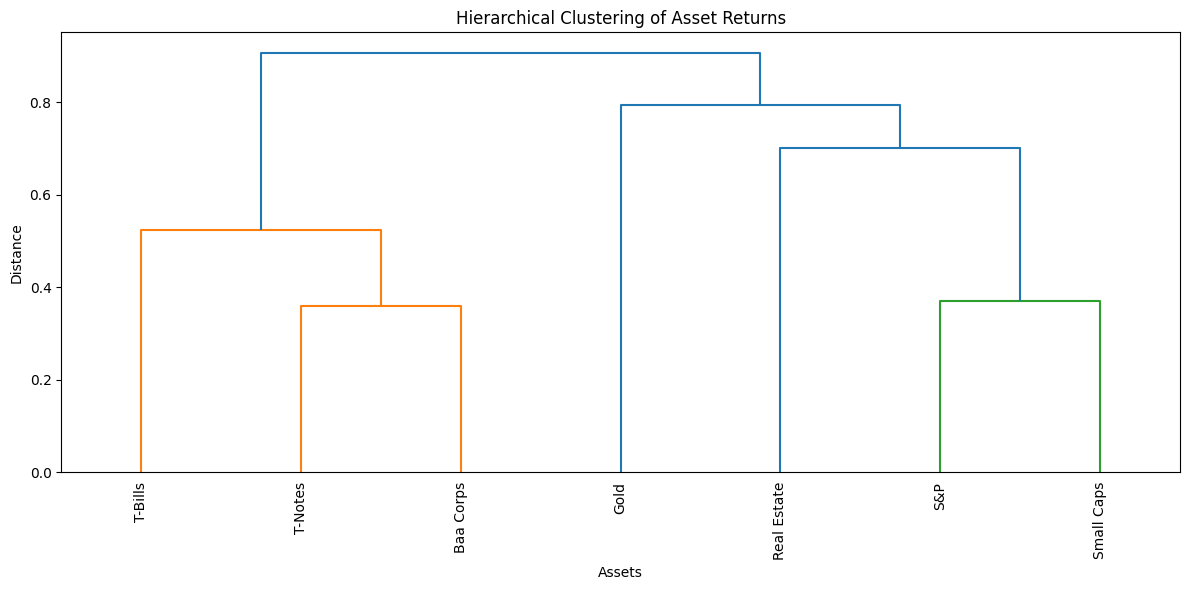

In [88]:
# compute HRP ourselves instead using riskfolio module

def cov_to_corr(cov):
    """Convert covariance matrix to correlation matrix."""
    if not np.allclose(cov, cov.T):  # check symmetry
        raise ValueError("Covariance matrix is not symmetric")
    sd = np.sqrt(np.diag(cov)) # covariance to SD
    corr = cov / np.outer(sd, sd) # scale cov[i,j] by dividing by sd[i[*sd[j] to get correlation
    # fix some numerical precision errors
    # Use isclose to fix values close to 0
    corr[np.isclose(corr, 0, atol=1e-9)] = 0
    # ensure not > 1 or < -1
    corr = np.clip(corr, -1, 1)
    return corr

def get_correlation_dist(corr):
    """Convert covariance matrix to a correlation distance matrix."""
    dist = np.sqrt((1 - corr)/2)
    dist = np.clip(dist, 0, None)      # fix numerical precision errors, dist never <0
    np.fill_diagonal(dist.values, 0)
    return dist

def show_dendrogram(linkage, labels):
    plt.figure(figsize=(12, 6))
    dendrogram(linkage,
               labels=labels,
               orientation='top',
               leaf_rotation=90,
               leaf_font_size=10,
               show_contracted=True
              )
    plt.title('Hierarchical Clustering of Asset Returns')
    plt.xlabel('Assets')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

# Calculate covariance matrix
covariance_matrix = df.cov()
# use Ledoit-Wolf robust covariance when more than 30 or so assets (cols = 30% of rows)
# Ledoit-Wolf is a cross between full covariance matrix and the one that would be generated by a single-factor beta model
# lw = LedoitWolf()
# covariance_matrix = pd.DataFrame(lw.fit(df).covariance_, index=df.columns, columns=df.columns)

correlation_matrix = cov_to_corr(covariance_matrix)
distance_matrix = get_correlation_dist(correlation_matrix)
# 'ward' method tends to create balanced clusters. original de Prado paper used single linkage
# riskfolio uses ward
# need to study this more, you want to balance max between-cluster distance and min within-cluster distance
# Ward's method: minimizes distance within clusters (need to understand how it avoids single element clusters with 0 distance)
# Single linkage (nearest point): minimum distance between any 2 members
# Complete linkage (furthest point): maximum distance between any members (ok but once you put farthest points in distinct clusters how to you determine the others)
# Average linkage: average distance between all members

link = linkage(squareform(distance_matrix), method='ward')
show_dendrogram(link, df.columns.tolist())

In [89]:
leaves_list(link)

array([2, 3, 4, 6, 5, 0, 1], dtype=int32)

In [90]:
df.columns[leaves_list(link)]

Index(['T-Bills', 'T-Notes', 'Baa Corps', 'Gold', 'Real Estate', 'S&P',
       'Small Caps'],
      dtype='object')

In [91]:
correlation_matrix

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
S&P,1.000000,0.724550,0.069003,0.090947,0.426188,0.188366,-0.068703
Small Caps,0.724550,1.000000,-0.055736,-0.038992,0.324654,0.199514,0.011566
T-Bills,0.069003,-0.055736,1.000000,0.571655,0.476199,-0.041325,-0.028018
T-Notes,0.090947,-0.038992,0.571655,1.000000,0.740479,-0.003644,-0.004880
Baa Corps,0.426188,0.324654,0.476199,0.740479,1.000000,0.080395,0.039756
Real Estate,0.188366,0.199514,-0.041325,-0.003644,0.080395,1.000000,-0.099097
Gold,-0.068703,0.011566,-0.028018,-0.004880,0.039756,-0.099097,1.000000


In [92]:
ordered_indices = leaves_list(link)
# reorder everything
correlation_matrix = correlation_matrix.iloc[ordered_indices, ordered_indices]
covariance_matrix = covariance_matrix.iloc[ordered_indices, ordered_indices]
distance_matrix = distance_matrix.iloc[ordered_indices, ordered_indices]
df = df.iloc[:, ordered_indices].copy()


In [93]:
correlation_matrix

,T-Bills,T-Notes,Baa Corps,Gold,Real Estate,S&P,Small Caps
T-Bills,1.000000,0.571655,0.476199,-0.028018,-0.041325,0.069003,-0.055736
T-Notes,0.571655,1.000000,0.740479,-0.004880,-0.003644,0.090947,-0.038992
Baa Corps,0.476199,0.740479,1.000000,0.039756,0.080395,0.426188,0.324654
Gold,-0.028018,-0.004880,0.039756,1.000000,-0.099097,-0.068703,0.011566
Real Estate,-0.041325,-0.003644,0.080395,-0.099097,1.000000,0.188366,0.199514
S&P,0.069003,0.090947,0.426188,-0.068703,0.188366,1.000000,0.724550
Small Caps,-0.055736,-0.038992,0.324654,0.011566,0.199514,0.724550,1.000000


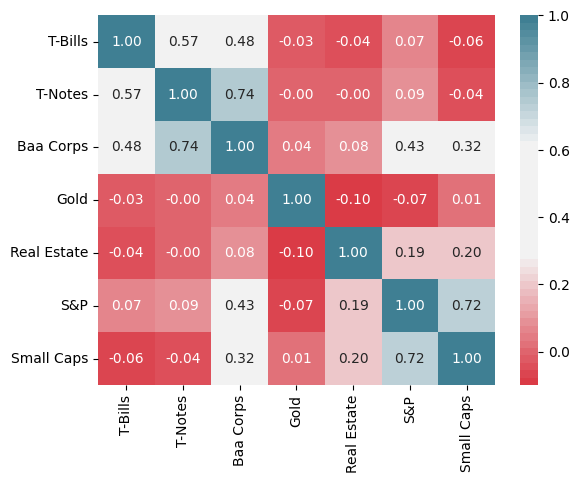

In [94]:
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(correlation_matrix, annot=True, fmt=".02f", cmap=my_cmap);
# can't help feeling corps should come before T-Notes, seems more correlated with S&P so WTF

In [95]:
# Example linkage array
# [[1, 3, 0.3, 2],    # Merge observations 1 & 3, distance=0.3, size=2 - create observation 4
#  [0, 4, 0.4, 3],    # Merge observations 0 & 4 (from step 1), distance=0.4, size=2 - create observation 5
#  [2, 5, 0.6, 4]]    # Merge observations 2 & 5 (from step 2), distance=0.6, size=3

# create a linkage array based on bisection
# basically throw out the tree and just make one based on the sort order that falls out of the linkage array
# this is how it was done in the original paper but frankly, we already have a tree that contains good info
# so I don't really understand why we wouldn't just use that.
# writing this code so we can go either way
# this will merge corps and T-notes, then stocks and gold, then merge both clusters.

def recursive_bisection(corr_matrix):
    """
    Perform recursive bisection on correlation matrix and return linkage-like structure
    Returns array with format similar to scipy.cluster.hierarchy.linkage:
    [[cluster1, cluster2, distance, size], ...]
    Really doesn't matter that the values are correlations, just uses the row/column order
    """
    n_children = len(corr_matrix)
    # Initialize with individual assets as clusters
    # Will store our linkage-like information
    bisection_links = []
    last_index = 0

    def split_cluster(cluster_indices):
        n_children = len(cluster_indices)
        if n_children <= 1:
            return cluster_indices
        else:
            split = n_children // 2
            return cluster_indices[split:], cluster_indices[:split]

    # Start with all assets in one cluster
    queue = [list(range(n_children))]

    while queue:
        current_cluster = queue.pop(0)
        if len(current_cluster) <= 1:
            continue

        # Split cluster
        cluster1, cluster2 = split_cluster(current_cluster)

        # Calculate distance (1 - avg correlation between clusters)
        avg_corr = corr_matrix.iloc[cluster1, cluster2].mean().mean()
        distance = 1 - avg_corr

        # Add to linkage-like structure
        if len(cluster1) > 1:
            cluster1_index = last_index - 1
            last_index = cluster1_index
        elif len(cluster1) == 1:
            cluster1_index = cluster1[0]
        else:
            print("error in bisection")

        if len(cluster2) > 1:
            cluster2_index = last_index - 1
            last_index = cluster2_index
        elif len(cluster2) == 1:
            cluster2_index = cluster2[0]
        else:
            print("error in bisection")

        bisection_links.append([
            cluster1_index, cluster2_index,  # use minimum index from each cluster
            distance,
            len(cluster1) + len(cluster2)
        ])

        # Add new clusters to queue if they're larger than 1
        if len(cluster1) > 1:
            queue.append(cluster1)
        if len(cluster2) > 1:
            queue.append(cluster2)

    n_new_clusters = -last_index
    highest_cluster_number = n_children + n_new_clusters - 1
    retarray = []
    for a in bisection_links:
        cluster1_index = highest_cluster_number + a[0] + 1 if a[0] < 0 else a[0]
        cluster2_index = highest_cluster_number + a[1] + 1 if a[1] < 0 else a[1]
        retarray.append([
            cluster1_index, cluster2_index,  # use minimum index from each cluster
            a[2],
            a[3]
        ])
    return list(reversed(retarray))

bisection_links = recursive_bisection(correlation_matrix)

bisection_links

[[2, 1, np.float64(0.25952050821469175), 2],
 [4, 3, np.float64(1.0990970463756675), 2],
 [6, 5, np.float64(0.27545037277455897), 2],
 [7, 0, np.float64(0.4760734002913044), 3],
 [9, 8, np.float64(0.917314237761717), 4],
 [11, 10, np.float64(0.9284708513099782), 7]]

In [96]:
# Create a 12x12 DataFrame of random numbers between -1 and 1
# random_df = pd.DataFrame(np.random.uniform(-1, 1, size=(12, 12)))

def recursive_bisection(corr_matrix):
    """
    Perform recursive bisection on ordered correlation matrix and return linkage-like structure.
    Returns array with format similar to scipy.cluster.hierarchy.linkage:
    [[cluster1, cluster2, distance, size], ...]
    """
    n = len(corr_matrix)
    bisection_links = []
    next_cluster_id = n

    def split_cluster(indices):
        """Split cluster into two parts based on current order"""
        mid = len(indices) // 2
        return indices[:mid], indices[mid:]

    def process_cluster(indices):
        """Recursively process clusters and build linkage structure"""
        if len(indices) <= 1:
            return indices[0]

        # Split cluster
        left_indices, right_indices = split_cluster(indices)

        # Process sub-clusters recursively
        left_id = process_cluster(left_indices) if len(left_indices) > 0 else None
        right_id = process_cluster(right_indices) if len(right_indices) > 0 else None

        # Calculate distance (1 - avg correlation between clusters)
        avg_corr = corr_matrix.iloc[left_indices, right_indices].mean().mean()
        distance = 1 - avg_corr

        # Add to linkage structure
        nonlocal next_cluster_id
        bisection_links.append([
            left_id,
            right_id,
            distance,
            len(left_indices) + len(right_indices)
        ])

        cluster_id = next_cluster_id
        next_cluster_id += 1
        return cluster_id

    # Start recursive process with all indices
    process_cluster(list(range(n)))

    return np.array(bisection_links)

# Example usage:
bisection_links = recursive_bisection(correlation_matrix)  # use the already ordered correlation matrix
print("Bisection linkage structure:")
print(bisection_links)


Bisection linkage structure:
[[ 1.          2.          0.25952051  2.        ]
 [ 0.          7.          0.4760734   3.        ]
 [ 3.          4.          1.09909705  2.        ]
 [ 5.          6.          0.27545037  2.        ]
 [ 9.         10.          0.91731424  4.        ]
 [ 8.         11.          0.92847085  7.        ]]


In [97]:
def calculate_hrp_weights(link, cov_matrix):
    """
    Calculate HRP portfolio weights using linkage structure

    Parameters:
    -----------
    link : numpy.ndarray
        Linkage matrix with shape (n-1, 4) where n is number of assets
    cov_matrix : pandas.DataFrame
        Covariance matrix of asset returns

    Returns:
    --------
    pandas.Series
        Portfolio weights indexed by asset names
    """
    # Input validation
    if not isinstance(cov_matrix, pd.DataFrame):
        raise TypeError("cov_matrix must be a pandas DataFrame")
    if not np.allclose(cov_matrix, cov_matrix.T):
        raise ValueError("cov_matrix must be symmetric")
    if link.shape[1] != 4:
        raise ValueError("link must have 4 columns (cluster1, cluster2, distance, size)")

    def cluster_variance(cluster_assets):
        """Calculate variance of a cluster using equal weights"""
        cluster_cov = cov_matrix.iloc[cluster_assets, cluster_assets]
        w = np.ones(len(cluster_assets)) / len(cluster_assets)
        variance = np.transpose(w) @ cluster_cov @ w
        return max(0, variance) # numerical stability check, force non-neg

    n = len(cov_matrix)
    weights = np.ones(n)

    # Initialize clusters dictionary: at start, each asset is in its own cluster
    clusters = {i: [i] for i in range(n)}

    # Process each merge from the linkage
    for i, row in enumerate(link):
        cluster1_idx = int(row[0])
        cluster2_idx = int(row[1])
        new_cluster_idx = n + i

        # Get assets in each cluster
        cluster1_assets = clusters[cluster1_idx]
        cluster2_assets = clusters[cluster2_idx]

        # Calculate cluster variances
        var1 = cluster_variance(cluster1_assets)
        var2 = cluster_variance(cluster2_assets)

        # Calculate weights
        alpha = 1 - (var1 / (var1 + var2))

        # Update weights
        for idx in cluster1_assets:
            weights[idx] *= alpha
        for idx in cluster2_assets:
            weights[idx] *= (1 - alpha)

        # Store the merged cluster
        clusters[new_cluster_idx] = cluster1_assets + cluster2_assets

        # Verify cluster size matches linkage info
        if len(clusters[new_cluster_idx]) != int(row[3]):
            raise ValueError(f"Cluster size mismatch at step {i}")

    # Normalize weights
    weights = weights / np.sum(weights)

    return pd.Series(weights, index=cov_matrix.index)

calculate_hrp_weights(bisection_links, covariance_matrix)

# doesn't match riskfolio
# S&P	T-Notes	Gold	Baa Corps
# weights	0.110835	0.311695	0.167578	0.409892

# matches pretty close if leaf_order = False
# 	S&P	T-Notes	Gold	Baa Corps
# weights	0.182752	0.225961	0.222854	0.368433

# TODO : look up how riskfolio enforces leaf order

T-Bills       0.689361
T-Notes       0.073520
Baa Corps     0.074504
Gold          0.008799
Real Estate   0.134283
S&P           0.015405
Small Caps    0.004128
dtype: float64

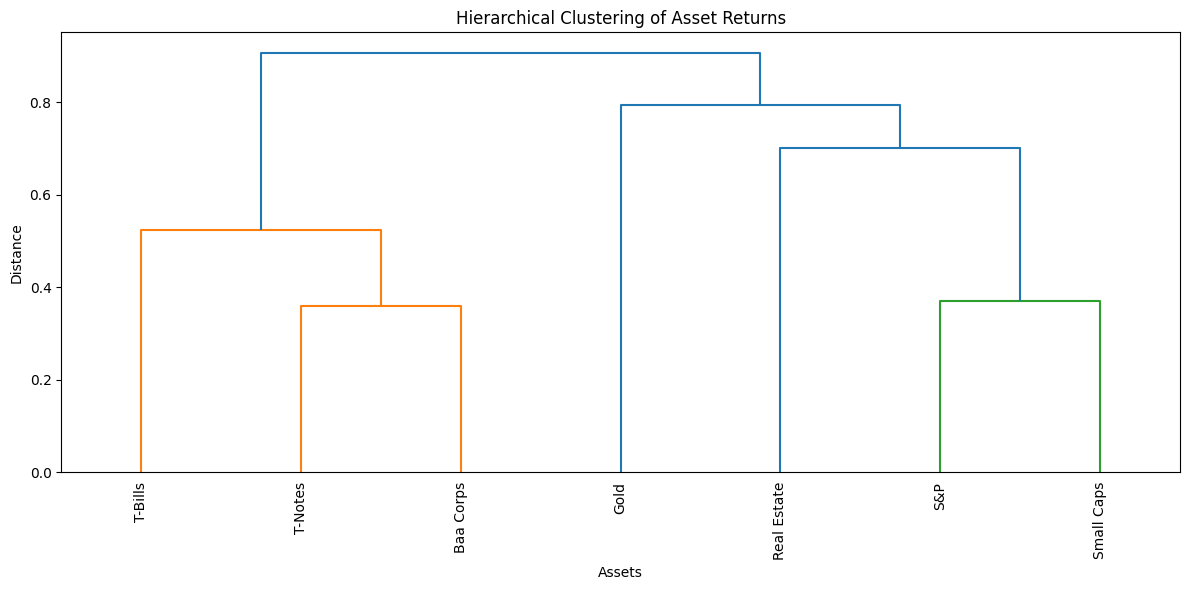

In [98]:
# redo this without bisecting, just use the tree created in the agglomerative clustering step.
# reorder df

# Calculate covariance matrix
covariance_matrix = df.cov()
# use Ledoit-Wolf robust covariance when more than 30 or so assets (cols = 30% of rows)
# Ledoit-Wolf is a cross between full covariance matrix and the one that would be generated by a single-factor beta model
# lw = LedoitWolf()
# covariance_matrix = pd.DataFrame(lw.fit(df).covariance_, index=df.columns, columns=df.columns)

correlation_matrix = cov_to_corr(covariance_matrix)
distance_matrix = get_correlation_dist(correlation_matrix)
# 'ward' method tends to create balanced clusters. original paper used single linkage
# riskfolio uses ward
# need to study this more, you want to balance max between-cluster distance and min within-cluster distance
# Ward's method: minimizes distance within clusters (need to understand how it avoids single element clusters with 0 distance)
# Single linkage (nearest point): minimum distance between any 2 members
# Complete linkage (furthest point): maximum distance between any members (ok but once you put farthest points in distinct clusters how to you determine the others)
# Average linkage: average distance between all members

link = linkage(squareform(distance_matrix), method='ward')
show_dendrogram(link, df.columns.tolist())


In [99]:
hrp_weights = calculate_hrp_weights(link, covariance_matrix)
hrp_weights

# more gold because merge is 2,3,4 instead fo 2,2,4

T-Bills       0.689361
T-Notes       0.073520
Baa Corps     0.074504
Gold          0.075453
Real Estate   0.084193
S&P           0.002341
Small Caps    0.000627
dtype: float64

In [100]:
def ret_table(df, wts):
    cols = wts.index.tolist()
    returns = df[cols] @ wts
    mu = returns.mean()
    sd = returns.std()
    sharpe = mu/sd
    print(f"Mean return: {100*mu:3.2f}%")
    print(f"Vol:         {100*sd:3.2f}%")
    print(f"Sharpe:      {mu/sd:3.3f}")

    return mu, sd, sharpe

ret_table(df, hrp_weights)


Mean return: 1.14%
Vol:         3.75%
Sharpe:      0.303


(np.float64(0.011381944503472718),
 np.float64(0.037514587102380204),
 np.float64(0.30340050051492007))

# Max Sharpe using portfoliooptimizer.io

In [101]:
# load API key for portfoliooptimizer.io
dotenv.load_dotenv()


True

In [102]:
# 1928-present
df = real_data_df.loc[1928:].copy()
df = df.drop(columns=['CPI', 'GDP'], errors='ignore')
df["TIPS"] = 0
labels = df.columns
n_years, n_assets = df.shape


In [103]:
mu = df.mean().to_list()
covmatrix = df.cov().values


In [104]:
# API endpoint and headers
BASEURL = "https://api.portfoliooptimizer.io/v1"
ENDPOINT = "portfolio/optimization/maximum-sharpe-ratio"
url = f"{BASEURL}/{ENDPOINT}"
print(url)

headers = {
    "Content-Type": "application/json",
    "Authorization": f'Bearer {os.getenv("PORTFOLIO_OPT_APIKEY")}'
}

# Payload
data = {
    "assets": n_assets,
    "assetsReturns": mu,
    "assetsCovarianceMatrix": covmatrix.tolist(),
    "riskFreeRate": 0
}

# Make the POST request
response = requests.post(url, json=data, headers=headers)

# Check and print the response
if response.status_code == 200:
    print("Response data:", response.json())
else:
    print("Error:", response.status_code, response.text)


https://api.portfoliooptimizer.io/v1/portfolio/optimization/maximum-sharpe-ratio
Response data: {'assetsWeights': [0.08470151286006943, 0.011293440461008067, 0, 0, 0.2031766958463755, 0.24226222768275343, 0.07635974451529251, 0.3822063786345011]}


In [105]:
wts = json.loads(response.text)['assetsWeights']
wts_df = pd.DataFrame({'Asset': df.columns.to_list(), 'Weight': wts}).set_index("Asset")
wts_df

# pretty close to above, note that we slice into 200 variances so discretization will impact it a little

# Max Sharpe Portfolio:
# Real Return: 3.63%
# SD:          6.16%
# T-Bills: 0.0%
# Real Estate: 39.3%
# T-Notes: 0.0%
# Baa Corps: 33.3%
# Gold: 11.9%
# S&P: 13.5%
# Small Caps: 2.0%

,Weight
Asset,
S&P,0.084702
Small Caps,0.011293
T-Bills,0.000000
T-Notes,0.000000
Baa Corps,0.203177
Real Estate,0.242262
Gold,0.076360
TIPS,0.382206


In [106]:
ret_table(df, wts_df["Weight"])


Mean return: 2.29%
Vol:         3.81%
Sharpe:      0.601


(np.float64(0.022886672824943645),
 np.float64(0.038089924656799334),
 np.float64(0.6008589681171292))

# Near optimal

[Near optimal portfolios](https://portfoliooptimizer.io/blog/mean-variance-optimization-in-practice-well-diversified-near-efficient-portfolios/) 

First find the highest Sharpe portfolio. Then, find the lowest risk portfolio with no more than e.g. a 0.05 drop in Sharpe ratio. Since this portfolio is more diversified, i.e. most diversified within 0.05 of maximum Sharpe, it should be more robust out-of-sample.


In [107]:
# 1928-present
df = real_data_df.loc[1928:].copy()
df = df.drop(columns=['CPI', 'GDP'], errors='ignore')
df["TIPS"] = 0
labels = df.columns
n_years, n_assets = df.shape


In [108]:
mu = df.mean().to_list()
covmatrix = df.cov().values


In [109]:
# docs
# https://docs.portfoliooptimizer.io/index.html#post-/portfolio/optimization/maximum-sharpe-ratio/diversified

# API endpoint and headers
BASEURL = "https://api.portfoliooptimizer.io/v1"
ENDPOINT = "portfolio/optimization/maximum-sharpe-ratio/diversified"
url = f"{BASEURL}/{ENDPOINT}"
print(url)

headers = {
    "Content-Type": "application/json",
    "Authorization": f'Bearer {os.getenv("PORTFOLIO_OPT_APIKEY")}'
}

# Payload
# I'm surprised there is no parameter for how 'near' is considered 'near optimal'

data = {
    "assets": n_assets,
    "assetsReturns": mu,
    "assetsCovarianceMatrix": covmatrix.tolist(),
    "riskFreeRate": 0
}

# Make the POST request
time.sleep(1) # can max out rate limit when run end to end

response = requests.post(url, json=data, headers=headers)

# Check and print the response
if response.status_code == 200:
    print("Response data:", response.json())
else:
    print("Error:", response.status_code, response.text)


https://api.portfoliooptimizer.io/v1/portfolio/optimization/maximum-sharpe-ratio/diversified
Response data: {'assetsWeights': [0.07816123925004238, 0.013319564796210218, 0.17354248692398497, 0.13859513158216535, 0.1236882654288838, 0.17714742524221055, 0.10561365053741965, 0.18993223623908323]}


In [110]:
wts = json.loads(response.text)['assetsWeights']
wts_df = pd.DataFrame({'Asset': df.columns.to_list(), 'Weight': wts}).set_index("Asset")
wts_df

,Weight
Asset,
S&P,0.078161
Small Caps,0.013320
T-Bills,0.173542
T-Notes,0.138595
Baa Corps,0.123688
Real Estate,0.177147
Gold,0.105614
TIPS,0.189932


In [111]:
ret_table(df, wts_df["Weight"])


Mean return: 2.32%
Vol:         4.19%
Sharpe:      0.553


(np.float64(0.023158853467257115),
 np.float64(0.04189895309093573),
 np.float64(0.5527310770031441))

# Subset Resampling

[Subset resampled portfolios](https://portfoliooptimizer.io/blog/mean-variance-optimization-in-practice-subset-resampling-based-efficient-portfolios/), Suppose we have 6 assets, do 6 optimizations, dropping one asset each time, then average all the portfolios. Similar to random forest, an ensemble of slightly weakened models is better than a single overfitted model.
    

In [112]:
# 1928-present
df = real_data_df.loc[1928:].copy()
df = df.drop(columns=['CPI', 'GDP'], errors='ignore')
df["TIPS"] = 0
labels = df.columns
n_years, n_assets = df.shape


In [113]:
mu = df.mean().to_list()
covmatrix = df.cov().values


In [114]:
# API endpoint and headers
BASEURL = "https://api.portfoliooptimizer.io/v1"
ENDPOINT = "portfolio/optimization/maximum-sharpe-ratio/subset-resampling-based"
url = f"{BASEURL}/{ENDPOINT}"
print(url)

headers = {
    "Content-Type": "application/json",
    "Authorization": f'Bearer {os.getenv("PORTFOLIO_OPT_APIKEY")}'
}

# Payload
data = {
    "assets": n_assets,
    "assetsReturns": mu,
    "assetsCovarianceMatrix": covmatrix.tolist(),
    "riskFreeRate": 0
}

# Make the POST request
time.sleep(1) # can max out rate limit when run end to end
response = requests.post(url, json=data, headers=headers)

# Check and print the response
if response.status_code == 200:
    print("Response data:", response.json())
else:
    print("Error:", response.status_code, response.text)


https://api.portfoliooptimizer.io/v1/portfolio/optimization/maximum-sharpe-ratio/subset-resampling-based
Response data: {'assetsWeights': [0.11139204472461273, 0.07933890124570096, 0.07899937553912188, 0.16270970540453286, 0.20031041697701055, 0.17265237522376636, 0.068576543175396, 0.12602063770985855]}


In [115]:
wts = json.loads(response.text)['assetsWeights']
wts_df = pd.DataFrame({'Asset': df.columns.to_list(), 'Weight': wts}).set_index("Asset")
wts_df


,Weight
Asset,
S&P,0.111392
Small Caps,0.079339
T-Bills,0.078999
T-Notes,0.162710
Baa Corps,0.200310
Real Estate,0.172652
Gold,0.068577
TIPS,0.126021


In [116]:
ret_table(df, wts_df["Weight"])


Mean return: 3.70%
Vol:         6.60%
Sharpe:      0.560


(np.float64(0.036967138270371735),
 np.float64(0.06597579908757002),
 np.float64(0.5603136116821421))

# Michaud Resampling


[Michaud resampling](https://docs.portfoliooptimizer.io/index.html#post-/portfolios/analysis/mean-variance/efficient-frontier/resampling-based) and [MCOS](https://github.com/enjine-com/mcos/tree/master). Do Monte Carlo simulations where we perturb the return forecasts and covariances randomly each time, and average all the resulting portfolios. 


In [117]:
# 1928-present
df = real_data_df.loc[1928:].copy()
df = df.drop(columns=['CPI', 'GDP'], errors='ignore')
df["TIPS"] = 0
labels = df.columns
n_years, n_assets = df.shape


In [118]:
mu = df.mean().to_list()
covmatrix = df.cov().values


In [119]:
# make intervals for mus , maybe should be a multiple of sds, not sure
mu_adjust = [m/3 for m in mu]
mu_adjust = [max(0.01, m) for m in mu_adjust] # at least 1% uncertainty interval or 30%
mu_intervals = list(zip([mu[i] - mu_adjust[i] for i in range(len(mu))],
                        [mu[i] + mu_adjust[i] for i in range(len(mu))]))
mu_intervals



[(0.05739017709335023, 0.11478035418670046),
 (0.09584209668042867, 0.19168419336085737),
 (-0.006017296116314929, 0.013982703883685072),
 (0.008335945400156574, 0.028335945400156576),
 (0.025706319500414444, 0.051412639000828896),
 (0.0025036947400576305, 0.02250369474005763),
 (0.027134537633089643, 0.054269075266179294),
 (-0.01, 0.01)]

In [120]:
# API endpoint and headers
BASEURL = "https://api.portfoliooptimizer.io/v1"
ENDPOINT = "portfolios/optimization/maximum-sharpe-ratio/resampling-based"
url = f"{BASEURL}/{ENDPOINT}"
print(url)

headers = {
    "Content-Type": "application/json",
    "Authorization": f'Bearer {os.getenv("PORTFOLIO_OPT_APIKEY")}'
}

# Payload
data = {
    "assets": n_assets,
    "assetsReturns": mu,
    "assetsReturnsUncertaintyIntervals": mu_intervals,
    "assetsCovarianceMatrix": covmatrix.tolist(),
    "riskFreeRate": 0,
#     "assetsCorrelationMatrixUncertaintyLevel": 0.25,
#     "portfolios": 100
}

# Make the POST request
time.sleep(1) # can max out rate limit when run end to end

response = requests.post(url, json=data, headers=headers)

# Check and print the response
if response.status_code == 200:
    print("Response data:", response.json())
else:
    print("Error:", response.status_code, response.text)


https://api.portfoliooptimizer.io/v1/portfolios/optimization/maximum-sharpe-ratio/resampling-based
Response data: {'assetsWeights': [0.059982008843768364, 0.016025714560913694, 0.08142555759519773, 0.01819258307385251, 0.12388155741306602, 0.15239550553943984, 0.0575772047490387, 0.49051986822472315]}


In [121]:
wts = json.loads(response.text)['assetsWeights']
wts_df = pd.DataFrame({'Asset': df.columns.to_list(), 'Weight': wts}).set_index("Asset")
wts_df

,Weight
Asset,
S&P,0.059982
Small Caps,0.016026
T-Bills,0.081426
T-Notes,0.018193
Baa Corps,0.123882
Real Estate,0.152396
Gold,0.057577
TIPS,0.490520


In [122]:
ret_table(df, wts_df["Weight"])


Mean return: 1.72%
Vol:         2.90%
Sharpe:      0.592


(np.float64(0.017151157853045888),
 np.float64(0.02898492006751668),
 np.float64(0.5917269329394198))

# Factors

Optimal portfolio after decomposing returns into risk factors with PCA/SVD.


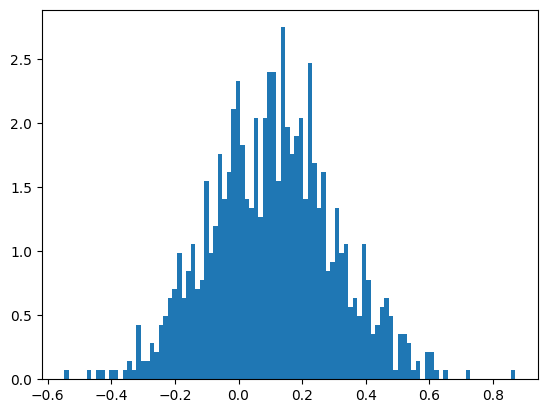

In [123]:
# we do this experiment with a synthetic portfolio
# number of stocksa
n = 1000
# historical mean returns for each stock
mu = np.random.normal(0.1, 0.2, n)

# number of factors
m = 10

# factor covariance matrix - random symmetrical matrix
SigmaFactor = np.random.randn(m, m)/4
SigmaFactor = SigmaFactor.T @ SigmaFactor

# factor loadings, determine volatility and covariances between stocks
F = np.random.randn(n, m)
# idiosyncratic risk of each stock
D = np.diag(np.random.uniform(0, 0.9, size=n))

count, bins, ignored = plt.hist(mu, 100, density=True, align='mid')


In [124]:
w = cp.Variable(n)         # what we solve for: weight for each stock
ret = mu.T @ w             # solve for weights that maximize portfolio return
f = F.T @ w                # portfolio factor loading
Lmax = cp.Parameter()      # leverage constraint
# portfolio volatility: factor risk + idiosyncratic risk
risk = cp.quad_form(f, SigmaFactor) + cp.quad_form(w, D)
prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1,
                   cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
prob.solve(solver=SOLVER, verbose=True, **SOLVER_PARAMS)

maxretvol = risk.value
maxret = ret.value
print("Max return portfolio (return=%.4f, vol=%.4f)" % (maxret, maxretvol))


(CVXPY) Feb 08 12:50:44 AM: Your problem has 1000 variables, 2 constraints, and 1 parameters.
(CVXPY) Feb 08 12:50:44 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 08 12:50:44 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 08 12:50:44 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Feb 08 12:50:44 AM: Compiling problem (target solver=CLARABEL).
(CVXPY) Feb 08 12:50:44 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Feb 08 12:50:44 AM: Applying reduction FlipObjective
(CVXPY) Feb 08 12:50:44 AM: Applying reduction Dcp2Cone
(CVXPY) Feb 08 12:50:44 AM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 08 12:50:44 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 08 12:50:44 AM: Applying reduction CLARABEL
(CVXPY) Feb 08 12:50:44 AM: Finished problem compilation (took 5.581e-03 seconds).
(CVXPY) Feb 08 12:50:44

                                     CVXPY                                     
                                     v1.8.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 2000
  constraint

(CVXPY) Feb 08 12:50:44 AM: Problem status: optimal
(CVXPY) Feb 08 12:50:44 AM: Optimal value: 1.580e+00
(CVXPY) Feb 08 12:50:44 AM: Compilation took 5.581e-03 seconds
(CVXPY) Feb 08 12:50:44 AM: Solver (including time spent in interface) took 8.816e-03 seconds


  0  -1.0885e-01  -2.8705e+00  2.76e+00  9.54e-01  6.95e-01  1.00e+00  1.38e+00   ------   
  1  -3.4974e+00  -3.8299e+00  9.50e-02  6.13e-01  9.08e-02  2.97e-02  1.84e-01  9.90e-01  
  2  -1.5372e+00  -1.6021e+00  4.22e-02  3.05e-01  5.33e-02  2.41e-02  1.13e-01  5.22e-01  
  3  -1.9811e+00  -2.0575e+00  3.86e-02  2.20e-01  5.12e-02  3.64e-02  1.12e-01  9.04e-02  
  4  -1.5871e+00  -1.6018e+00  9.31e-03  4.72e-02  1.61e-02  1.34e-02  3.79e-02  6.91e-01  
  5  -1.5594e+00  -1.5691e+00  6.27e-03  2.87e-02  1.05e-02  8.02e-03  2.52e-02  3.51e-01  
  6  -1.6054e+00  -1.6163e+00  6.79e-03  3.17e-02  1.05e-02  7.53e-03  2.45e-02  2.25e-01  
  7  -1.5753e+00  -1.5780e+00  1.69e-03  6.88e-03  2.52e-03  1.59e-03  6.03e-03  7.61e-01  
  8  -1.5799e+00  -1.5799e+00  4.58e-05  1.50e-04  5.53e-05  2.11e-05  1.33e-04  9.90e-01  
  9  -1.5799e+00  -1.5799e+00  4.58e-07  1.50e-06  5.54e-07  2.11e-07  1.33e-06  9.90e-01  
 10  -1.5799e+00  -1.5799e+00  4.58e-09  1.50e-08  5.54e-09  2.11e-09  1.33e-08 

In [125]:
# solve min vol portfolio (other corner solution)

prob = cp.Problem(cp.Minimize(risk),
                  [cp.sum(w) == 1,
                   cp.norm(w, 1) <= Lmax])
prob.solve(solver=SOLVER, **SOLVER_PARAMS)

minvol = risk.value
minvolret = ret.value
print("Min vol portfolio (return=%.4f, risk=%.4f)" % (minvolret, minvol))


Min vol portfolio (return=0.1053, risk=0.0002)


In [126]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility
# might have to run a couple of times to get a solution

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1,
                   cp.norm(w, 1) <= Lmax,
                   risk <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve(solver=SOLVER, verbose=False, **SOLVER_PARAMS)
    return (ret.value, np.sqrt(risk.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vl_vals = np.square(vl_vals)
# vol constraint is in variance space, take square root of minvol and maxvol, linspace, square values)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)

# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


<timed exec>:18: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.


CPU times: user 3.71 s, sys: 90.8 ms, total: 3.81 s
Wall time: 4.43 s


In [127]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'var']
ret_df['return'] = [results_dict[v][0] for v in ret_df['var']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['var']]
# ret_df


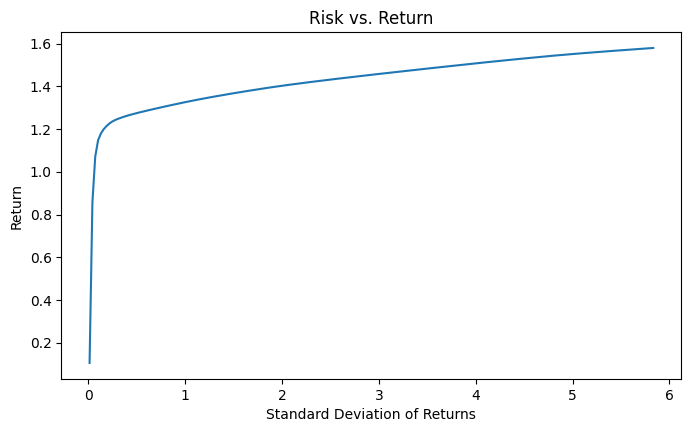

In [128]:
# plot frontier
plt.figure(figsize=(8, 4.5))
#plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Returns")
plt.ylabel("Return")
plt.title("Risk vs. Return")

# plot the data
plt.plot(x,y);


### Or compute factors with historical data

In [129]:
# login to openbb with email and password
# obb.account.login(email=os.environ['OPENBB_USER'], password=os.environ['OPENBB_PW'], remember_me=True)
# Validate OpenBB PAT credentials
openbb_pat = os.getenv('OPENBB_PAT')
if not openbb_pat:
    raise ValueError("OPENBB_PAT environment variable not set")
obb.user.credentials.openbb_pat = openbb_pat


# probably a way to get S&P components from OpenBB but this didn't give tickers, have to map lei to ticker, might need a paid provider sub
# response = obb.etf.holdings(symbol='VOO', provider='sec')
# response.results[0]


In [130]:
# get tickers from Wikipedia
ticker_list = ['A',
 'AAPL',
 'ABBV',
 'ABNB',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APO',
 'APTV',
 'ARE',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBY',
 'BDX',
 'BEN',
 'BF-B',
 'BG',
 'BIIB',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRK-B',
 'BRO',
 'BSX',
 'BWA',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CARR',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDNS',
 'CDW',
 'CE',
 'CEG',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CRWD',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTRA',
 'CTSH',
 'CTVA',
 'CVS',
 'CVX',
 'CZR',
 'D',
 'DAL',
 'DAY',
 'DD',
 'DE',
 'DECK',
 'DELL',
 'DFS',
 'DG',
 'DGX',
 'DHI',
 'DHR',
 'DIS',
 'DLR',
 'DLTR',
 'DOC',
 'DOV',
 'DOW',
 'DPZ',
 'DRI',
 'DTE',
 'DUK',
 'DVA',
 'DVN',
 'DXCM',
 'EA',
 'EBAY',
 'ECL',
 'ED',
 'EFX',
 'EG',
 'EIX',
 'EL',
 'ELV',
 'EMN',
 'EMR',
 'ENPH',
 'EOG',
 'EPAM',
 'EQIX',
 'EQR',
 'EQT',
 'ERIE',
 'ES',
 'ESS',
 'ETN',
 'ETR',
 'EVRG',
 'EW',
 'EXC',
 'EXPD',
 'EXPE',
 'EXR',
 'F',
 'FANG',
 'FAST',
 'FCX',
 'FDS',
 'FDX',
 'FE',
 'FFIV',
 'FI',
 'FICO',
 'FIS',
 'FITB',
 'FMC',
 'FOX',
 'FOXA',
 'FRT',
 'FSLR',
 'FTNT',
 'FTV',
 'GD',
 'GDDY',
 'GE',
 'GEHC',
 'GEN',
 'GEV',
 'GILD',
 'GIS',
 'GL',
 'GLW',
 'GM',
 'GNRC',
 'GOOG',
 'GOOGL',
 'GPC',
 'GPN',
 'GRMN',
 'GS',
 'GWW',
 'HAL',
 'HAS',
 'HBAN',
 'HCA',
 'HD',
 'HES',
 'HIG',
 'HII',
 'HLT',
 'HOLX',
 'HON',
 'HPE',
 'HPQ',
 'HRL',
 'HSIC',
 'HST',
 'HSY',
 'HUBB',
 'HUM',
 'HWM',
 'IBM',
 'ICE',
 'IDXX',
 'IEX',
 'IFF',
 'INCY',
 'INTC',
 'INTU',
 'INVH',
 'IP',
 'IPG',
 'IQV',
 'IR',
 'IRM',
 'ISRG',
 'IT',
 'ITW',
 'IVZ',
 'J',
 'JBHT',
 'JBL',
 'JCI',
 'JKHY',
 'JNJ',
 'JNPR',
 'JPM',
 'K',
 'KDP',
 'KEY',
 'KEYS',
 'KHC',
 'KIM',
 'KKR',
 'KLAC',
 'KMB',
 'KMI',
 'KMX',
 'KO',
 'KR',
 'KVUE',
 'L',
 'LDOS',
 'LEN',
 'LH',
 'LHX',
 'LII',
 'LIN',
 'LKQ',
 'LLY',
 'LMT',
 'LNT',
 'LOW',
 'LRCX',
 'LULU',
 'LUV',
 'LVS',
 'LW',
 'LYB',
 'LYV',
 'MA',
 'MAA',
 'MAR',
 'MAS',
 'MCD',
 'MCHP',
 'MCK',
 'MCO',
 'MDLZ',
 'MDT',
 'MET',
 'META',
 'MGM',
 'MHK',
 'MKC',
 'MKTX',
 'MLM',
 'MMC',
 'MMM',
 'MNST',
 'MO',
 'MOH',
 'MOS',
 'MPC',
 'MPWR',
 'MRK',
 'MRNA',
 'MS',
 'MSCI',
 'MSFT',
 'MSI',
 'MTB',
 'MTCH',
 'MTD',
 'MU',
 'NCLH',
 'NDAQ',
 'NDSN',
 'NEE',
 'NEM',
 'NFLX',
 'NI',
 'NKE',
 'NOC',
 'NOW',
 'NRG',
 'NSC',
 'NTAP',
 'NTRS',
 'NUE',
 'NVDA',
 'NVR',
 'NWS',
 'NWSA',
 'NXPI',
 'O',
 'ODFL',
 'OKE',
 'OMC',
 'ON',
 'ORCL',
 'ORLY',
 'OTIS',
 'OXY',
 'PANW',
 'PARA',
 'PAYC',
 'PAYX',
 'PCAR',
 'PCG',
 'PEG',
 'PEP',
 'PFE',
 'PFG',
 'PG',
 'PGR',
 'PH',
 'PHM',
 'PKG',
 'PLD',
 'PLTR',
 'PM',
 'PNC',
 'PNR',
 'PNW',
 'PODD',
 'POOL',
 'PPG',
 'PPL',
 'PRU',
 'PSA',
 'PSX',
 'PTC',
 'PWR',
 'PYPL',
 'QCOM',
 'RCL',
 'REG',
 'REGN',
 'RF',
 'RJF',
 'RL',
 'RMD',
 'ROK',
 'ROL',
 'ROP',
 'ROST',
 'RSG',
 'RTX',
 'RVTY',
 'SBAC',
 'SBUX',
 'SCHW',
 'SHW',
 'SJM',
 'SLB',
 'SMCI',
 'SNA',
 'SNPS',
 'SO',
 'SOLV',
 'SPG',
 'SPGI',
 'SRE',
 'STE',
 'STLD',
 'STT',
 'STX',
 'STZ',
 'SW',
 'SWK',
 'SWKS',
 'SYF',
 'SYK',
 'SYY',
 'T',
 'TAP',
 'TDG',
 'TDY',
 'TECH',
 'TEL',
 'TER',
 'TFC',
 'TFX',
 'TGT',
 'TJX',
 'TMO',
 'TMUS',
 'TPL',
 'TPR',
 'TRGP',
 'TRMB',
 'TROW',
 'TRV',
 'TSCO',
 'TSLA',
 'TSN',
 'TT',
 'TTWO',
 'TXN',
 'TXT',
 'TYL',
 'UAL',
 'UBER',
 'UDR',
 'UHS',
 'ULTA',
 'UNH',
 'UNP',
 'UPS',
 'URI',
 'USB',
 'V',
 'VICI',
 'VLO',
 'VLTO',
 'VMC',
 'VRSK',
 'VRSN',
 'VRTX',
 'VST',
 'VTR',
 'VTRS',
 'VZ',
 'WAB',
 'WAT',
 'WBA',
 'WBD',
 'WDAY',
 'WDC',
 'WEC',
 'WELL',
 'WFC',
 'WM',
 'WMB',
 'WMT',
 'WRB',
 'WST',
 'WTW',
 'WY',
 'WYNN',
 'XEL',
 'XOM',
 'XYL',
 'YUM',
 'ZBH',
 'ZBRA',
 'ZTS']

In [131]:
# download historical returns from Yahoo Finance
todays_date = datetime.today()
start_date = datetime(year=todays_date.year-10, month=todays_date.month, day=todays_date.day)
start_date_str = start_date.strftime("%Y-%m-%d")
symbol = "BF-B"
df = obb.equity.price.historical(symbol = symbol,
                                 start_date = start_date,
                                 provider="yfinance",
                                 adjustment='splits_and_dividends').to_df()
df.head()

,open,high,low,close,volume,split_ratio,dividend
date,,,,,,,
2016-02-08,31.980797,32.041074,31.337831,31.585642,2421250,0.000000,0.000000
2016-02-09,31.478482,32.389349,31.444996,32.101357,2465250,0.000000,0.000000
2016-02-10,32.255404,32.416146,31.773180,31.907131,1907500,0.000000,0.000000
2016-02-11,31.498587,32.151597,31.431610,32.007599,2235250,0.000000,0.000000
2016-02-12,32.459684,32.620426,32.041087,32.489822,1430000,0.000000,0.000000


In [132]:
# download all tickers
df = obb.equity.price.historical(symbol = ticker_list,
                                 start_date = start_date,
                                 provider="yfinance",
                                 adjustment='splits_and_dividends').to_df()
# too big to display
# df



8 Failed downloads:
['DFS', 'JNPR', 'ANSS', 'PARA', 'FI', 'WBA', 'IPG', 'HES']: YFTzMissingError('possibly delisted; no timezone found')


In [133]:
df = df[["symbol", "close"]].copy()
df.head()


,symbol,close
date,,
2016-02-08,A,32.130970
2016-02-08,AAPL,21.538042
2016-02-08,ABBV,34.981743
2016-02-08,ABT,31.067009
2016-02-08,ACGL,21.439592


In [134]:
# fix index
df = df.reset_index()
df["date"] = pd.to_datetime(df["date"])
df.head()


,date,symbol,close
0,2016-02-08,A,32.130970
1,2016-02-08,AAPL,21.538042
2,2016-02-08,ABBV,34.981743
3,2016-02-08,ABT,31.067009
4,2016-02-08,ACGL,21.439592


In [135]:
df_pivot = df.pivot(index="date", columns=["symbol"], values="close")
df_pivot.head()


symbol,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-02-08,32.130970,21.538042,34.981743,NaN,31.067009,21.439592,81.172371,74.940002,40.341396,24.711794,...,96.584633,15.841270,51.764126,28.827261,52.372959,32.038383,40.489361,82.373108,54.439999,37.079311
2016-02-09,32.657261,21.533510,35.371979,NaN,30.685513,21.512493,79.678207,73.849998,40.464497,24.919588,...,96.141502,15.624640,51.456017,29.099009,52.145069,32.471813,39.912914,82.256752,54.680000,36.774860
2016-02-10,33.100430,21.370287,34.869301,NaN,30.859676,21.832630,80.438095,75.529999,40.177265,24.622742,...,93.421913,15.353851,51.183098,28.900709,51.669720,32.224136,40.087048,83.160774,57.799999,36.285892
2016-02-11,32.620304,21.241077,34.512150,NaN,30.138149,21.147984,79.772125,74.940002,40.078800,23.686665,...,93.083046,15.042439,52.547630,28.636307,51.832512,32.029537,39.174347,82.059837,57.639999,36.313564
2016-02-12,33.442074,21.306824,34.776703,NaN,30.793327,21.680485,80.856468,76.669998,40.735291,24.300734,...,93.699944,15.299690,60.866859,28.511442,52.763680,32.763702,40.435318,82.149338,59.310001,37.300747


In [136]:
# save
df_pivot.to_pickle("df_pivot.pkl")


In [137]:
df_pivot.shape


(2515, 495)

In [138]:
# change from daily to monthly returns
dfx = df_pivot \
    .resample('ME') \
    .last() \
    .pct_change() \
    .dropna(axis=0, how='all') \
    .dropna(axis=1)      # drop columns with missing data




/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_33714/78992865.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change() \


In [139]:
dfx.shape


(120, 469)

In [140]:

pca = PCA()
pca_result = pca.fit_transform(dfx)


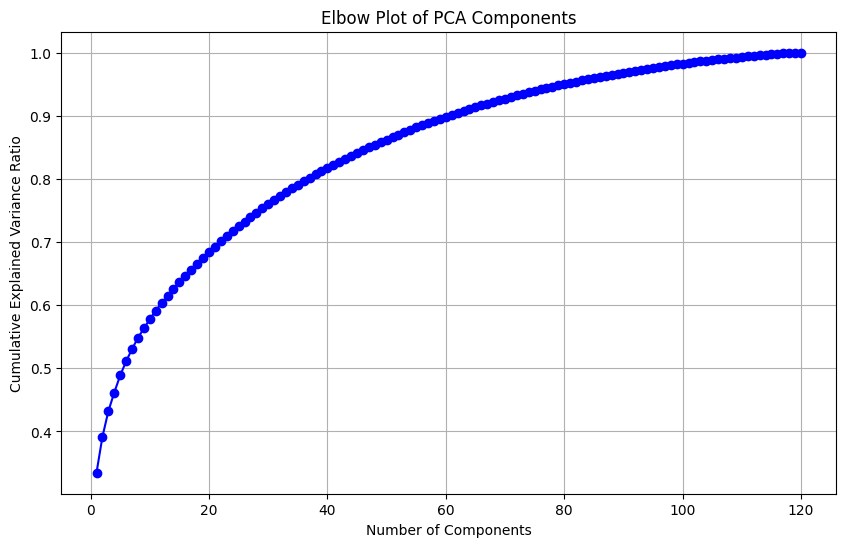

In [141]:
# chart eigenvalues

explained_variance_ratio = pca.explained_variance_ratio_

# Create elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1),
         np.cumsum(explained_variance_ratio), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Elbow Plot of PCA Components')
plt.grid(True)
plt.show()


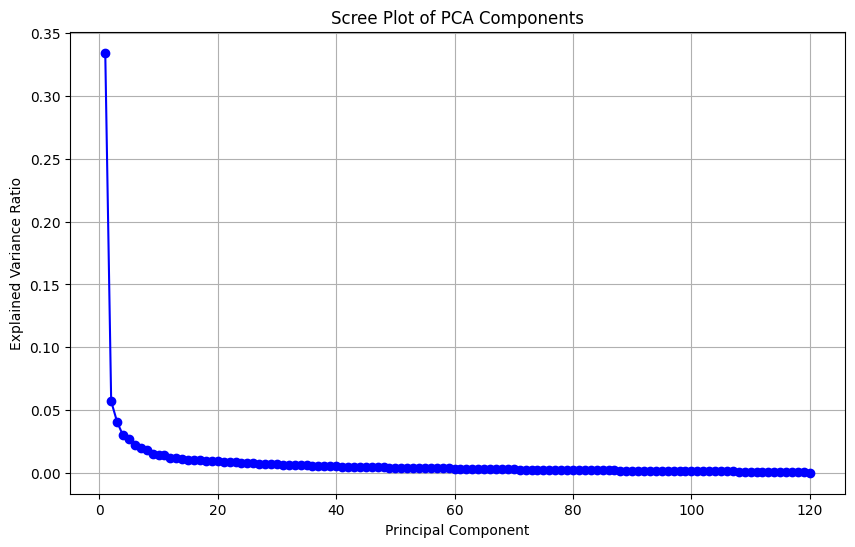

In [142]:
# scree plot with individual variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA Components')
plt.grid(True)
plt.show()


In [143]:
components = pca.fit_transform(dfx)
reconstructed = pca.inverse_transform(components)

# Calculate reconstruction error
difference = np.abs(dfx - reconstructed)
reconstruction_error = np.mean(difference)

print("Reconstruction Error (Mean Absolute Difference):")
print(reconstruction_error)


Reconstruction Error (Mean Absolute Difference):
1.5264658270677767e-16


In [144]:
reconstructed_data = np.dot(components, pca.components_) + pca.mean_
reconstructed_df = pd.DataFrame(reconstructed_data, columns=dfx.columns)

# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(dfx.reset_index(drop=True) - reconstructed_df))
print("Reconstruction Error (Mean Absolute Difference):", reconstruction_error)


Reconstruction Error (Mean Absolute Difference): 1.5264658270677767e-16


In [145]:
# reconstruct but with 20 columns
components.shape


(120, 120)

In [146]:
pca.components_ .shape


(120, 469)

In [147]:
# could use e.g. 20 factors that explain ~ 70% of variation
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=dfx.columns
)
loadings.T

symbol,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
PC1,0.044903,0.037399,0.025558,0.026875,0.027685,0.042817,0.041075,0.050497,0.035356,0.031670,...,0.028907,0.064720,0.080806,0.011513,0.044535,0.042315,0.037720,0.043623,0.068801,0.030279
PC2,-0.051933,-0.060300,0.013480,-0.043530,0.018652,-0.052834,-0.074072,-0.007847,0.033724,-0.015343,...,-0.001642,0.002645,0.045350,-0.028233,0.096619,-0.033395,-0.007104,0.000576,-0.040354,-0.062207
PC3,-0.012971,0.015355,-0.026502,-0.037514,-0.029268,-0.008376,0.029548,0.032011,-0.032922,-0.017426,...,-0.025407,-0.026672,0.052062,-0.072083,-0.032577,0.005378,-0.063661,-0.054140,0.065959,-0.024849
PC4,-0.027741,0.041514,-0.012857,0.007143,-0.054863,0.038288,0.075449,-0.010813,-0.038098,0.011270,...,-0.015237,-0.012989,0.019187,-0.041137,0.001881,-0.028256,0.009430,0.013447,0.022310,0.009949
PC5,0.021365,0.021554,-0.000691,-0.003884,-0.065394,-0.015414,-0.023905,0.061291,0.027218,-0.022070,...,-0.034854,0.027607,0.009666,0.008098,0.039193,0.018296,-0.011491,-0.014457,0.004185,-0.010239
PC6,0.007615,-0.047003,-0.001748,-0.004844,-0.042393,-0.035545,-0.061210,0.020056,0.011009,-0.010630,...,-0.036821,0.016122,0.011428,-0.048950,-0.028778,-0.016006,-0.033189,0.008886,0.053040,0.043450
PC7,-0.013478,0.037671,-0.057721,-0.011047,-0.053311,-0.028832,-0.014001,0.017535,-0.024313,-0.033573,...,0.003428,0.037954,0.085592,0.060679,-0.028170,-0.020680,0.039029,-0.003020,0.003117,0.015600
PC8,-0.071696,-0.013792,-0.023737,-0.051295,0.050381,-0.007532,-0.019922,0.022451,-0.028173,0.029031,...,0.003819,-0.023014,0.019946,0.009707,0.008167,0.023487,0.027230,-0.026904,-0.029653,0.005671
PC9,-0.027577,-0.046133,-0.015847,0.005334,0.002821,0.012323,-0.011635,-0.032210,-0.054318,0.046569,...,0.007218,0.045088,-0.025590,0.003904,-0.028432,0.036515,0.005859,-0.011178,0.021288,0.006912
PC10,0.013280,0.043049,-0.059234,-0.023817,0.031536,0.005029,0.040951,-0.003032,0.035509,0.045473,...,-0.000753,-0.065543,-0.115255,0.057781,0.014040,-0.004157,-0.029792,-0.051394,0.001777,-0.038282


In [148]:
# rest left as an exercise for the reader for now, may revisit later
# compute efficient frontier of portfolios of top 20 factors
# compute max sharpe portfolio
# back out individual stock weights
# compute backward looking performance, vol, sharpe